In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import signal, ndimage
import emd
import scipy.io as sio

In [3]:
data_hpc = sio.loadmat(r"C:\Users\capta\Projects\Radbound University\LFP_CBD_chronic_downsampled (1)\HPC_100_CH14_0.continuous.mat")
data_states = sio.loadmat(r"C:\Users\capta\Projects\Radbound University\LFP_CBD_chronic_downsampled (1)\2021-07-06_15-49-34_posttrial5-states_ES.mat"
                         )


In [4]:
data_hpc

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Jun 25 15:51:09 2022',
 '__version__': '1.0',
 '__globals__': [],
 'HPC': array([[3266.4978835 ],
        [3143.18335021],
        [3179.5555727 ],
        ...,
        [ 245.05036138],
        [ 211.60425328],
        [ 181.30351928]])}

In [5]:
HPC = data_hpc['HPC']


In [6]:
data_states

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Feb 10 11:43:16 2022',
 '__version__': '1.0',
 '__globals__': [],
 'states': array([[1, 1, 1, ..., 1, 1, 1]], dtype=uint8),
 'events': array([], shape=(0, 0), dtype=uint8),
 'transitions': array([[1.00000000e+00, 6.07638889e-03, 5.32626975e+03],
        [1.00000000e+00, 4.84761914e+03, 1.08016797e+04],
        [3.00000000e+00, 8.45896267e+02, 1.65548481e+03],
        [3.00000000e+00, 6.12277778e+02, 6.79117622e+02],
        [1.00000000e+00, 6.76474392e+02, 6.79356337e+02],
        [3.00000000e+00, 7.68187500e+02, 8.93918403e+02],
        [1.00000000e+00, 9.19534722e+02, 9.36001736e+02],
        [3.00000000e+00, 9.32359809e+02, 9.82385851e+02],
        [1.00000000e+00, 9.82751736e+02, 9.99782986e+02],
        [4.00000000e+00, 1.29498872e+03, 1.31596094e+03],
        [1.00000000e+00, 1.31603863e+03, 1.36698481e+03],
        [3.00000000e+00, 1.41117405e+03, 1.43188151e+03],
        [1.00000000e+00, 1.31562847e+03, 1.

In [7]:
states = data_states['states']

In [9]:
lfp = np.squeeze(HPC
                )
states = np.squeeze(states)

In [10]:
import numpy as np

def findIntervalsA(booString):
    """
    This function takes a boolean string and returns the start and end indices of consecutive True values.

    Parameters:
        booString (numpy array) : A boolean numpy array where True values indicate the presence of a condition.

    Returns:
        numpy array : A 2D numpy array where each row represents an interval of consecutive True values in the input.
        The first column is the start index and the second column is the end index of the interval.

    Note:
    The function assumes that the input is a 1D boolean numpy array. If the input does not meet this assumption, the function may not work as expected.
    """
    booString = booString.reshape((1, len(booString)))

    starts = np.where(np.diff((np.concatenate(([False], booString[0]), axis=0)).astype(int)) > 0)[0]
    ends = np.where(np.diff((np.concatenate((booString[0], [False]), axis=0)).astype(int))< 0)[0]

    intervals = np.vstack((starts, ends)).T
    return intervals

def ConsolidateIntervalsFast(intervals, strict='off', epsilon=0):
    """
    Merge together the intervals that are overlapping.

    Parameters:
        intervals (list of tuples): List of intervals (e.g., [(start1, end1), (start2, end2), ...]).
        strict (str, optional): Intervals with common bounds are consolidated ('off') or kept separate ('on').
            Default is 'off'.
        epsilon (float, optional): Intervals with close enough bounds (distance lesser than epsilon) are also
            consolidated. Default is 0.

    Returns:
        list of tuples: Consolidated intervals.
        list of int: For each original interval, the index of the consolidated
            interval to which it belongs (empty intervals yield NaN).

    Note:
        Assumes the intervals are sorted in time and that no interval is completely contained within another.
    """
    if len(intervals) == 0:
        raise ValueError("Input list of intervals cannot be empty.")

    # Get difference between two consecutive intervals
    vector = np.array(intervals).flatten()
    d = np.diff(vector)
    d = d[1::2]

    # Define problematic spots
    if strict == 'on':
        problematic = d < epsilon
    else:
        problematic = d <= epsilon
    # Leave function if intervals don't need consolidating
    if not np.any(problematic):
        consolidated = intervals
        return consolidated

    # Mark already consolidated intervals
    problematic_etendu = np.concatenate(([False], problematic, [False]))
    done = [intervals[i] for i in range(len(intervals)) if not problematic_etendu[i] and not problematic_etendu[i+1]]


    # Initialize consolidated intervals and target list
    indices = toIntervals(problematic)
    for i in range(len(indices)):
      indices[i] = (indices[i][0], indices[i][1] + 1)
    fixed= [ (x, y) for x, y in zip([intervals[int(i) - 1][0] for i, _ in indices], [intervals[int(i) - 1][1] for _, i in indices]) ]
    #fixed = [tuple([intervals[int(i) - 1][0] for i, _ in indices], [intervals[int(i) - 1][1] for _, i in indices])]
    # Concatenate done and fixed vertically
    if done != [] and fixed != []:
      consolidated = np.vstack((done, fixed))
    elif done == []:
       consolidated = [list(el) for el in fixed]
    else:
       consolidated = [list(el) for el in done]
    # Sort the rows of consolidated based on the first column
    consolidated = np.array(consolidated)

    # Sort the rows of consolidated based on the first column
    consolidated = consolidated[consolidated[:, 0].argsort()]
    consolidated = [tuple(row) for row in consolidated]
    target = [None] * len(intervals)
    # Initialize variables for the current interval
    current_start, current_end = intervals[0]
    current_target = 1

    # Convert target indices to 1-based indexing
    target = [t + 1 if t is not None else None for t in target]
    # Return the consolidated intervals
    return consolidated

def toIntervals(x, in_ = None):
    """
    Convert logical vector to a list of intervals.

    Parameters:
        x (list) : values, e.g. timestamps
        in_ (boolean list, optional) : boolean list of the same length as x;
    Returns:
        list : A list of tuples where each tuple represents an interval. Each tuple contains two elements: the start and end of the interval.

    Note:
    _in  can also be omitted, in which case x needs to be a boolean list
    and the intervals are defined in terms of indices in the logical vector.
    """
    if len(x) == 0:
        raise ValueError('Incorrect number of parameters .')

    if in_ is None:
        in_ = np.array(in_)
        in_ = x
        x = np.linspace(1, len(x) + 1, len(x) + 1)
    else:
        in_ = np.array(in_)
        if not np.all(np.isfinite(x)):
            raise ValueError('Incorrect x values.')

    if in_[-1] == 1:
        in_ = np.append(in_, 0)

    din = np.diff(np.concatenate(([0], in_)))
    start = np.where(din == 1)[0]
    stop = np.where(din == -1)[0]

    ivs = np.column_stack((start, stop - 1))
    if len(x) > 0:
        ivs = x[ivs]

    return ivs

def InIntervals(values, intervals):
    """
    Test which values fall in a list of sorted intervals.

    Parameters:
        values (list): Sorted list of values to test.
        intervals (list of tuples): Sorted list of (start, stop) pairs representing the intervals.

    Returns:
        list: Boolean values indicating whether each value is in an interval.
    """
    result = []
    interval_index = 0

    for value in values:
        while interval_index < len(intervals) and intervals[interval_index][1] < value:
            interval_index += 1

        if interval_index < len(intervals) and intervals[interval_index][0] <= value <= intervals[interval_index][1]:
            result.append(True)
        else:
            result.append(False)

    return result

def removeArtefacts(lfp_sig, originalFreq, amp_thresh, time_win_thresh):
    """
    Removes artefacts from the LFP signal.

    Parameters:
        lfp_sig (numpy.ndarray): The LFP signal.
        originalFreq (float): The sampling frequency.
        amp_thresh (tuple): The amplitude thresholds for detecting artefacts.
                            The first one corresponds to the threshold for the absolute value of the z-scored signal.
                            The second one corresponds to the threshold to the absolute difference between a value and its predecessor of the z-scored signal.
        time_win_thresh (tuple): The time windows that will be set to zero before and after the detected artefacts.
                                 The first one corresponds to the window for the absolute value of the z-scored signal.
                                 The second one corresponds to the window for the absolute difference between a value and its predecessor of the z-scored signal.
    Returns:
        numpy.ndarray: The corrected LFP signal.
        numpy.ndarray: The indices of the artefacts.
        numpy.ndarray: The corresponding time.

    Note :
        This function only set to zero the detected artefacts.
    """
    time = np.linspace(0, len(lfp_sig)/originalFreq, len(lfp_sig))
    lfp_sig = np.array(lfp_sig)
    # Parameters
    threshold1 = amp_thresh[0]  # in sigmas deviating from the mean
    aroundArtefact1 = time_win_thresh[0]  # 2, Big and long artefacts
    threshold2 = amp_thresh[1]  # for derivative of z-scored signal
    aroundArtefact2 = time_win_thresh[1]  # 0.1 Very fast fluctuations (short time scale)

    # Performing the computations
    timeValues = time
    sig_values = lfp_sig.copy()
    z_sig = (sig_values - np.mean(sig_values)) / np.std(sig_values)
    z_sig = np.ravel(z_sig)
    diff_sig = np.concatenate((np.diff(z_sig),[0]), axis=0)
    artefactInds = np.zeros(len(sig_values), dtype=bool)
    findIntervalsA(np.abs(z_sig)>threshold1)
    # First we detect the large global artefacts
    artefactInterval = timeValues[findIntervalsA(np.abs(z_sig)>threshold1)]
    #if np.size(artefactInterval) == 2:
      #artefactInterval = np.ravel(artefactInterval)
    if artefactInterval.size != 0:
      array_artefactInterval= [ (x, y) for x, y in zip(artefactInterval[:,0]-aroundArtefact1, artefactInterval[:,1]+aroundArtefact1) ]
      artefactInterval = ConsolidateIntervalsFast(array_artefactInterval);
      artefactInds = InIntervals(timeValues, artefactInterval)
    else:
      artefactInterval = np.zeros((0, 2))

    # Find noise using the derivative of the zscored signal (2)
    noisyInterval = timeValues[findIntervalsA(np.abs(diff_sig)>threshold2)]
    #if np.size(noisyInterval) == 2:
      #noisyInterval = np.ravel(noisyInterval)
    if noisyInterval.size != 0:
      array_noisyInterval= [ (x, y) for x, y in zip(noisyInterval[:,0]-aroundArtefact2, noisyInterval[:,1]+aroundArtefact2) ]
      noisyInterval = ConsolidateIntervalsFast(array_noisyInterval);
      artefactInds = np.logical_or(artefactInds, InIntervals(timeValues, noisyInterval))
    else:
      noisyInterval = np.zeros((0, 2))

    artefactInds = np.array(artefactInds)
    sig_values = np.ravel(sig_values)
    sig_values[artefactInds] = 0

    return sig_values, artefactInds, timeValues

def artefact_epochs(artefactsIndices, window_length, threshold = 0):
    """
    Get the indices of the epochs containing artefacts

    Parameters:
        artefactsIndices (list): the indices of the artefacts in the raw data.
        window_length (int) : the length of an epoch
        threshold (float, optional) : percentage of artefact necessary for an epoch to be detected as an artefact.

    Returns:
        numpy.ndarray : the indices of the epochs containing a percetage of artefacts greater than the threshold.
    """
    artefactsCountEpochs = artefactsIndices[:len(artefactsIndices)//window_length * window_length].reshape(-1, window_length)
    artefactsCountEpochs = [np.count_nonzero(el) for el in artefactsCountEpochs]
    art_percentage_per_epoch = np.ravel([(el/(window_length))*100  for el in artefactsCountEpochs])

    arte_indices = []
    for i, el in enumerate(art_percentage_per_epoch):
        if el > threshold:
            arte_indices.append(i)
    arte_indices = np.ravel(arte_indices)
    return arte_indices

In [11]:
hpc_clean, hpcNoisyIdx, timeValues = removeArtefacts(lfp, 1000, [4, 8], [1, 0.1])

In [50]:
timeValues.shape

(27004246,)

In [12]:
lfp = hpc_clean

In [13]:
#starting analysis

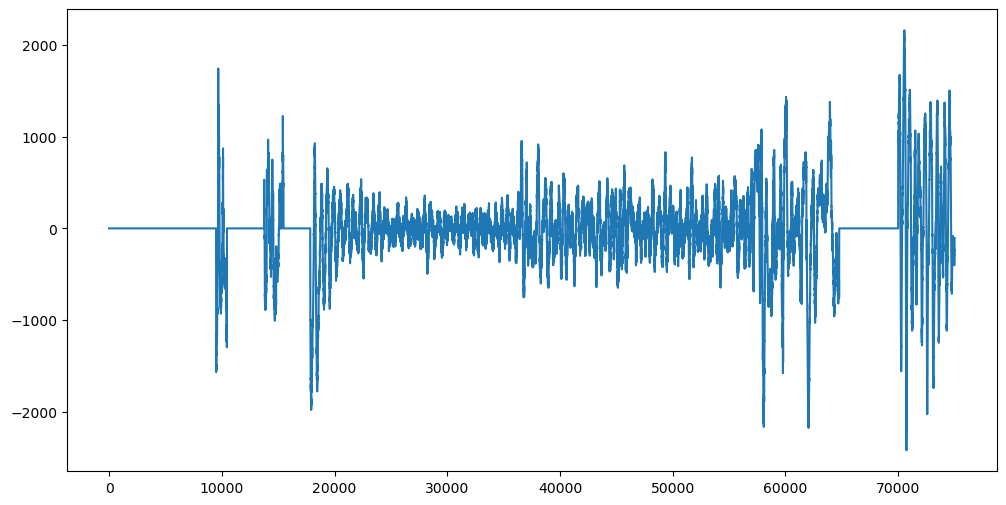

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(lfp[50*2500:80*2500])

In [15]:
len(states)/2500

4.3204

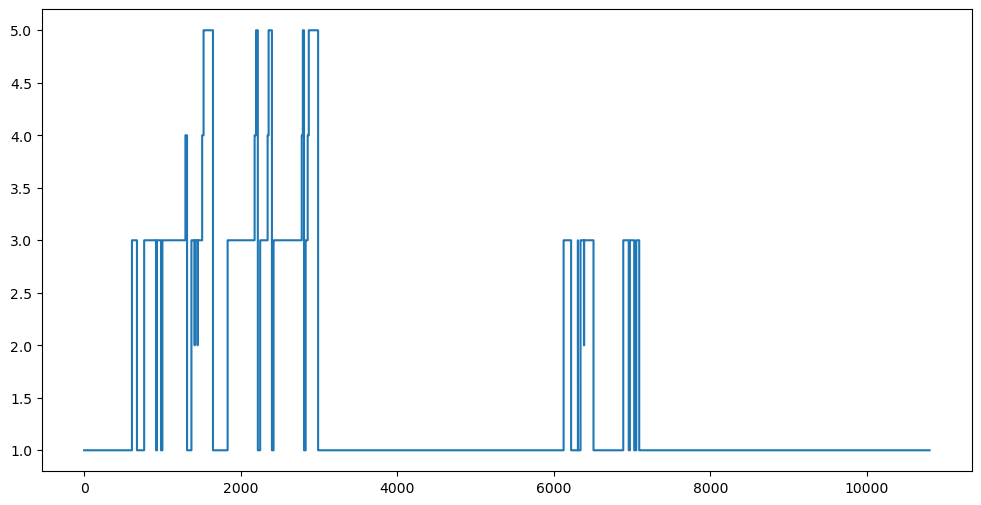

In [16]:
plt.figure(figsize=(12, 6))
time = np.arange(len(states))
plt.step(time, states)

In [17]:
def get_rem_states(states, sample_rate):
    """
    Extract consecutive REM (Rapid Eye Movement) sleep states from a binary sleep state vector.

    Parameters:
    states (numpy.ndarray): A sleep state vector where 5 represents REM sleep and other values indicate non-REM.
    sample_rate (int or float): The sampling rate of the data.

    Returns:
    numpy.ndarray: An array of consecutive REM sleep state intervals in seconds, represented as (start, end) pairs.

    Notes:
    - This function processes a binary sleep state vector and identifies consecutive REM sleep intervals.
    - It calculates the start and end times of each REM state interval based on the provided sample rate.
    - The resulting intervals are returned as a numpy array of (start, end) pairs in seconds.
    """
    states = np.squeeze(states)
    rem_state_indices = np.where(states == 5)[0]
    rem_state_changes = np.diff(rem_state_indices)
    split_indices = np.where(rem_state_changes != 1)[0] + 1
    split_indices = np.concatenate(([0], split_indices, [len(rem_state_indices)]))
    consecutive_rem_states = np.empty((len(split_indices) - 1, 2))
    for i, (start, end) in enumerate(zip(split_indices, split_indices[1:])):
        start = rem_state_indices[start] * int(sample_rate)
        end = rem_state_indices[end - 1] * int(sample_rate)
        consecutive_rem_states[i] = np.array([start, end])
    consecutive_rem_states = np.array(consecutive_rem_states)
    null_states_mask = np.squeeze(np.diff(consecutive_rem_states) > 0)
    consecutive_rem_states = consecutive_rem_states[null_states_mask]
    return consecutive_rem_states

In [18]:
s_rate= 2500
rem_states=get_rem_states(states, s_rate).astype(int)

for i,rem in enumerate(rem_states,start=1):
  print(f'REM {i} is from {rem[0]/s_rate} seconds (@ index {rem[0]}) to {rem[1]/s_rate} seconds (@ index {rem[1]})')
     

REM 1 is from 1527.0 seconds (@ index 3817500) to 1646.0 seconds (@ index 4115000)
REM 2 is from 2197.0 seconds (@ index 5492500) to 2219.0 seconds (@ index 5547500)
REM 3 is from 2358.0 seconds (@ index 5895000) to 2399.0 seconds (@ index 5997500)
REM 4 is from 2795.0 seconds (@ index 6987500) to 2809.0 seconds (@ index 7022500)
REM 5 is from 2871.0 seconds (@ index 7177500) to 2989.0 seconds (@ index 7472500)


In [19]:
first_rem=lfp[rem_states[0,0]:rem_states[0,1]]

In [20]:
first_rem.shape

(297500,)

<Axes: xlabel='Time (samples)'>

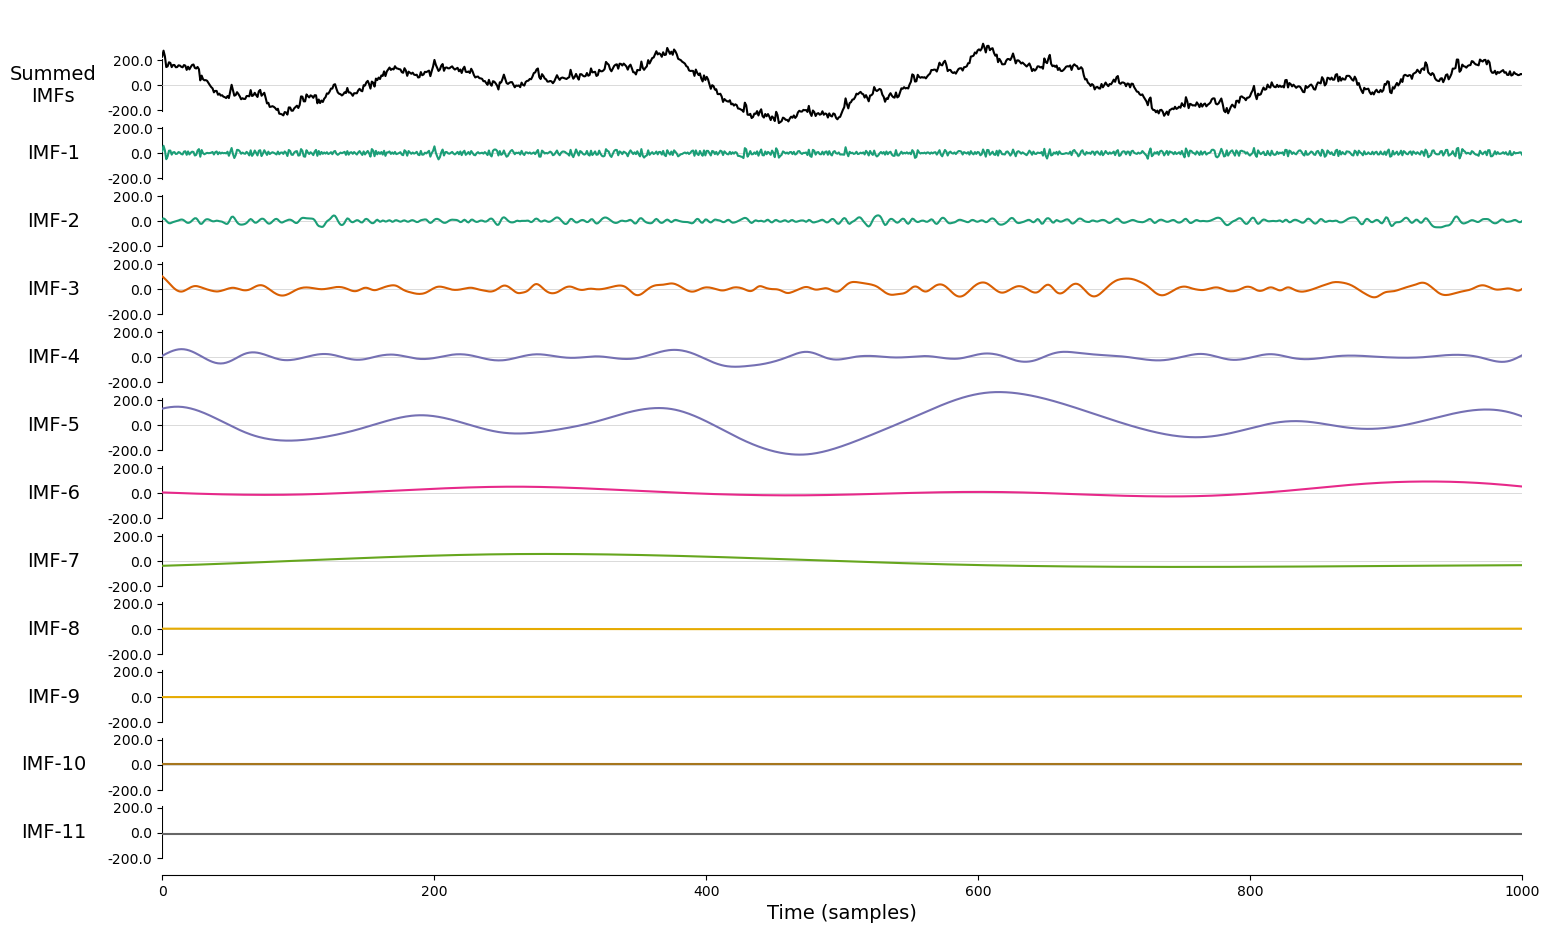

In [22]:
imf = emd.sift.sift(first_rem)
emd.plotting.plot_imfs(imf[:1000,:])

<Axes: xlabel='Time (samples)'>

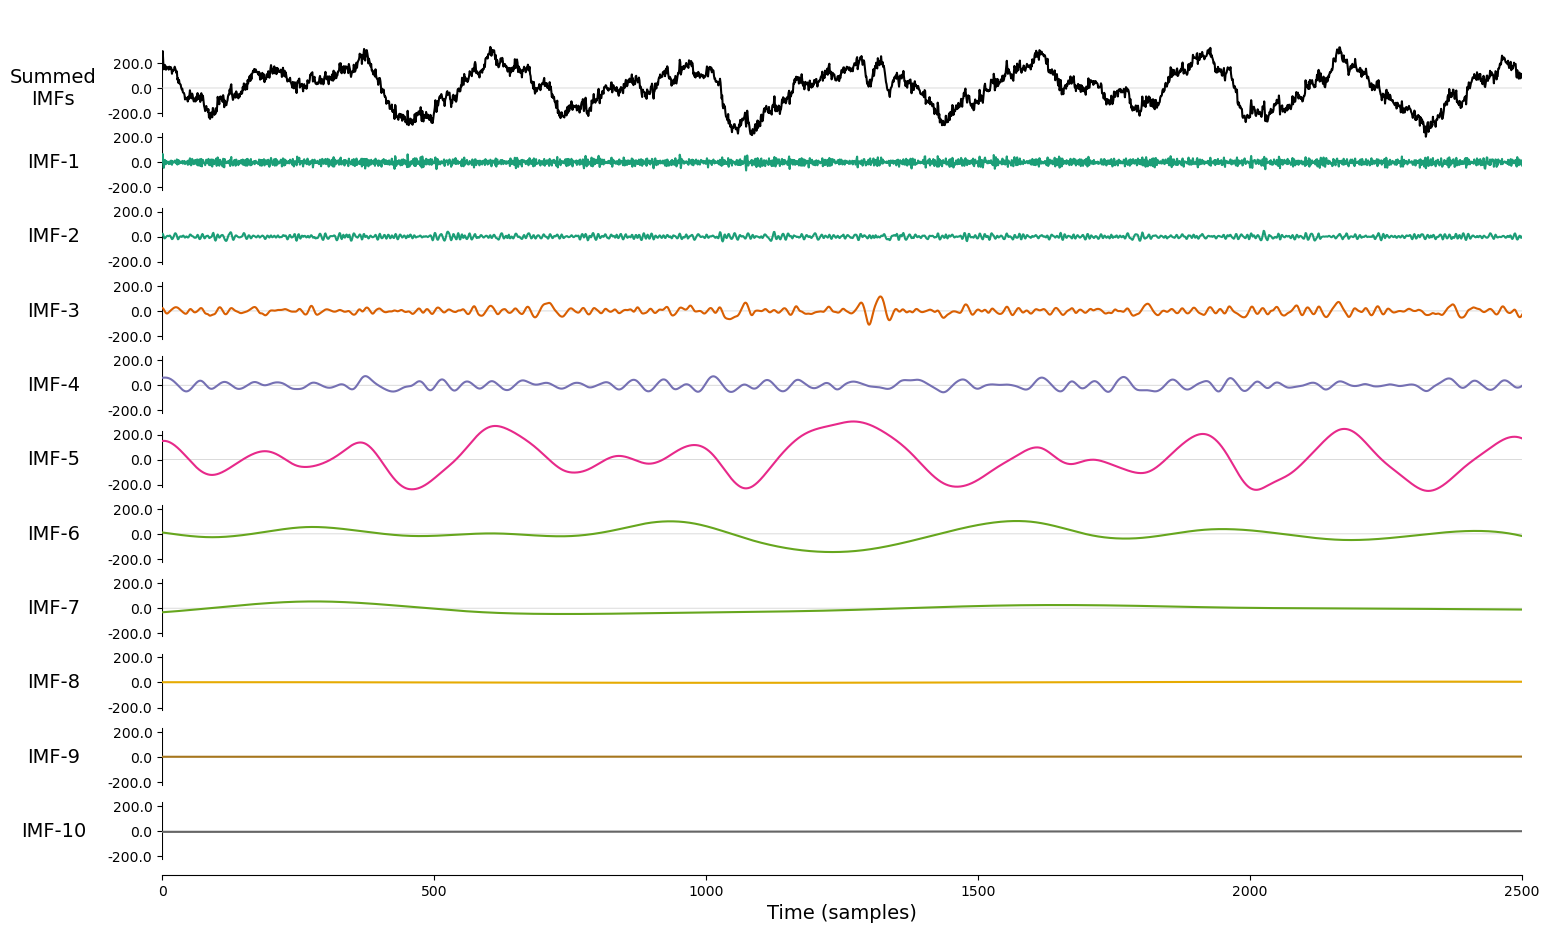

In [25]:
ensimf = emd.sift.ensemble_sift(first_rem)
emd.plotting.plot_imfs(ensimf[:2500])

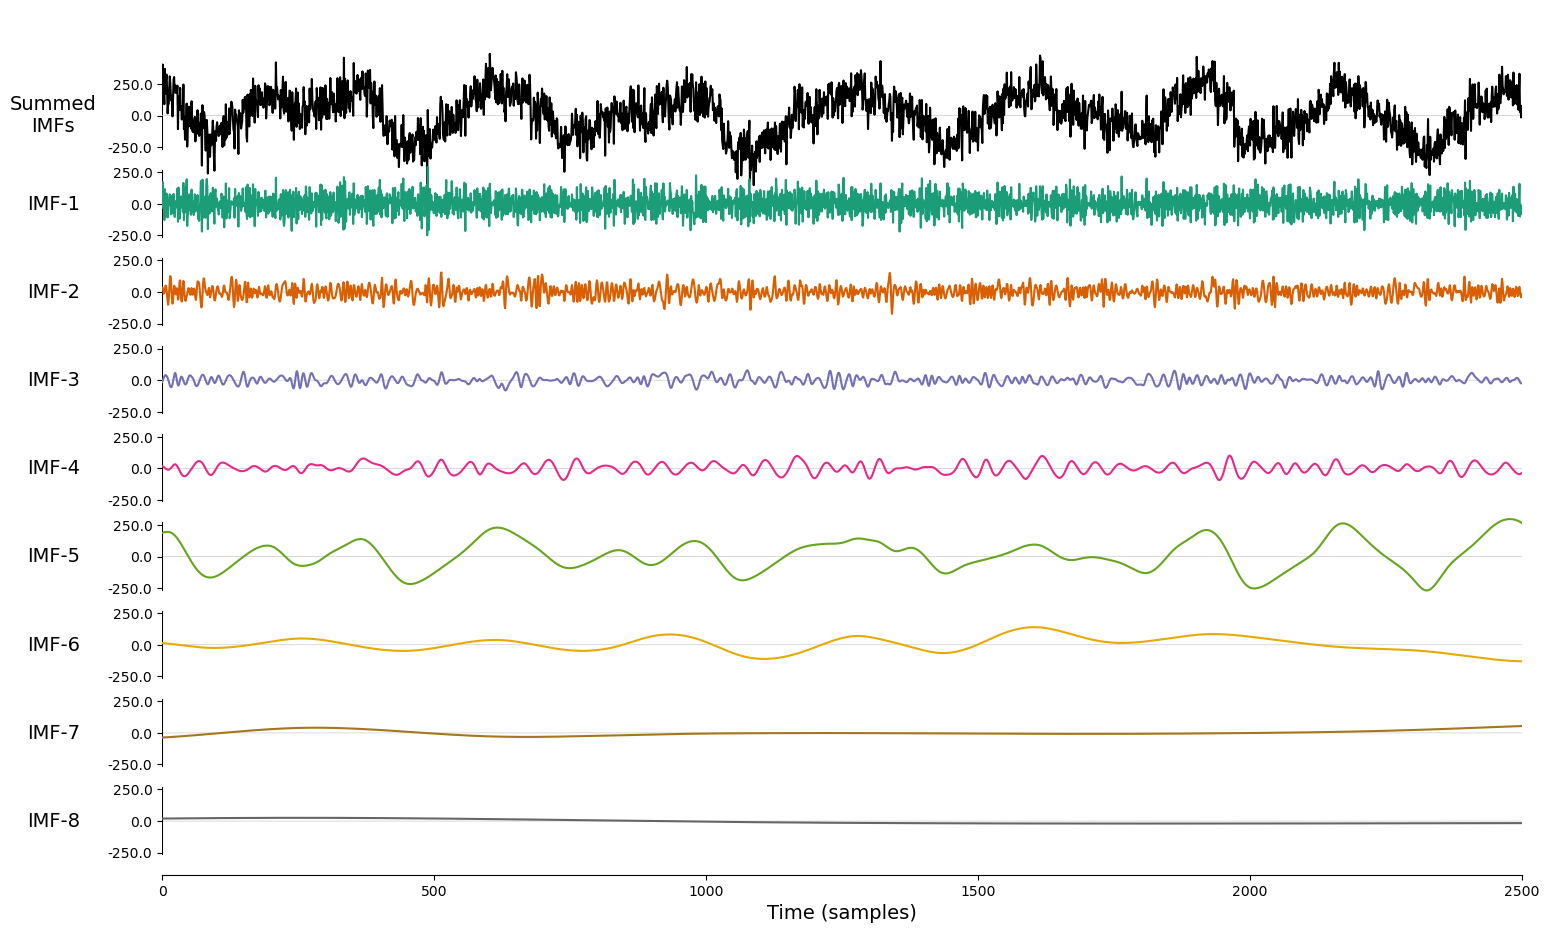

In [31]:
ensimf = emd.sift.ensemble_sift(first_rem, max_imfs=8,nensembles =2, nprocesses=6,ensemble_noise = 1)
ensimfig_2 = emd.plotting.plot_imfs(ensimf[:2500]).get_figure()

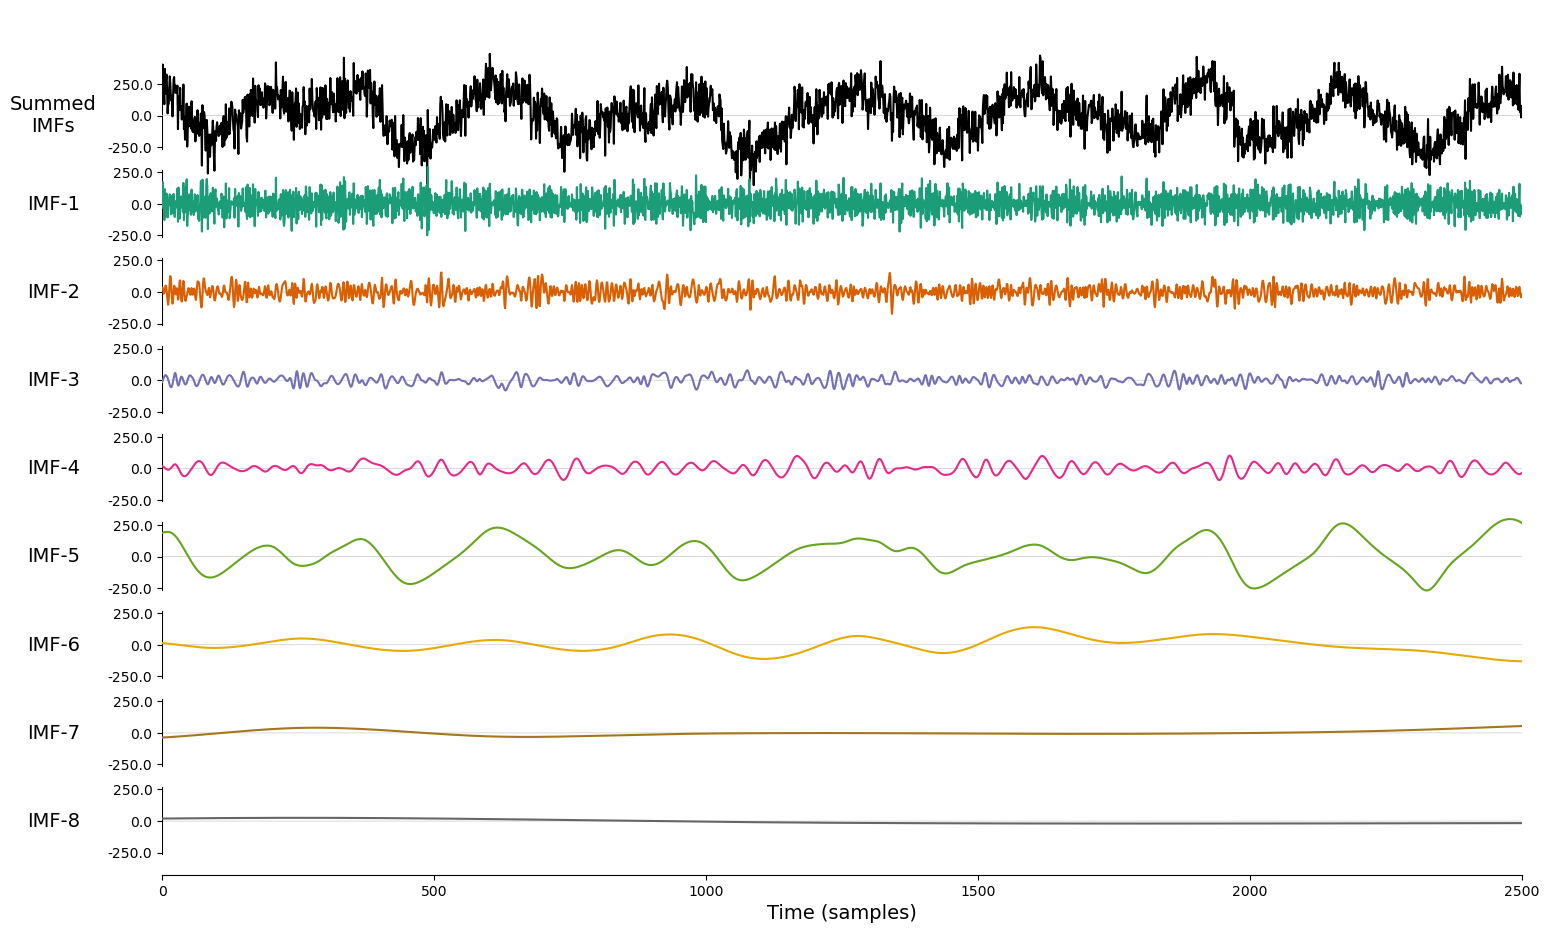

In [32]:
ensimfig_2

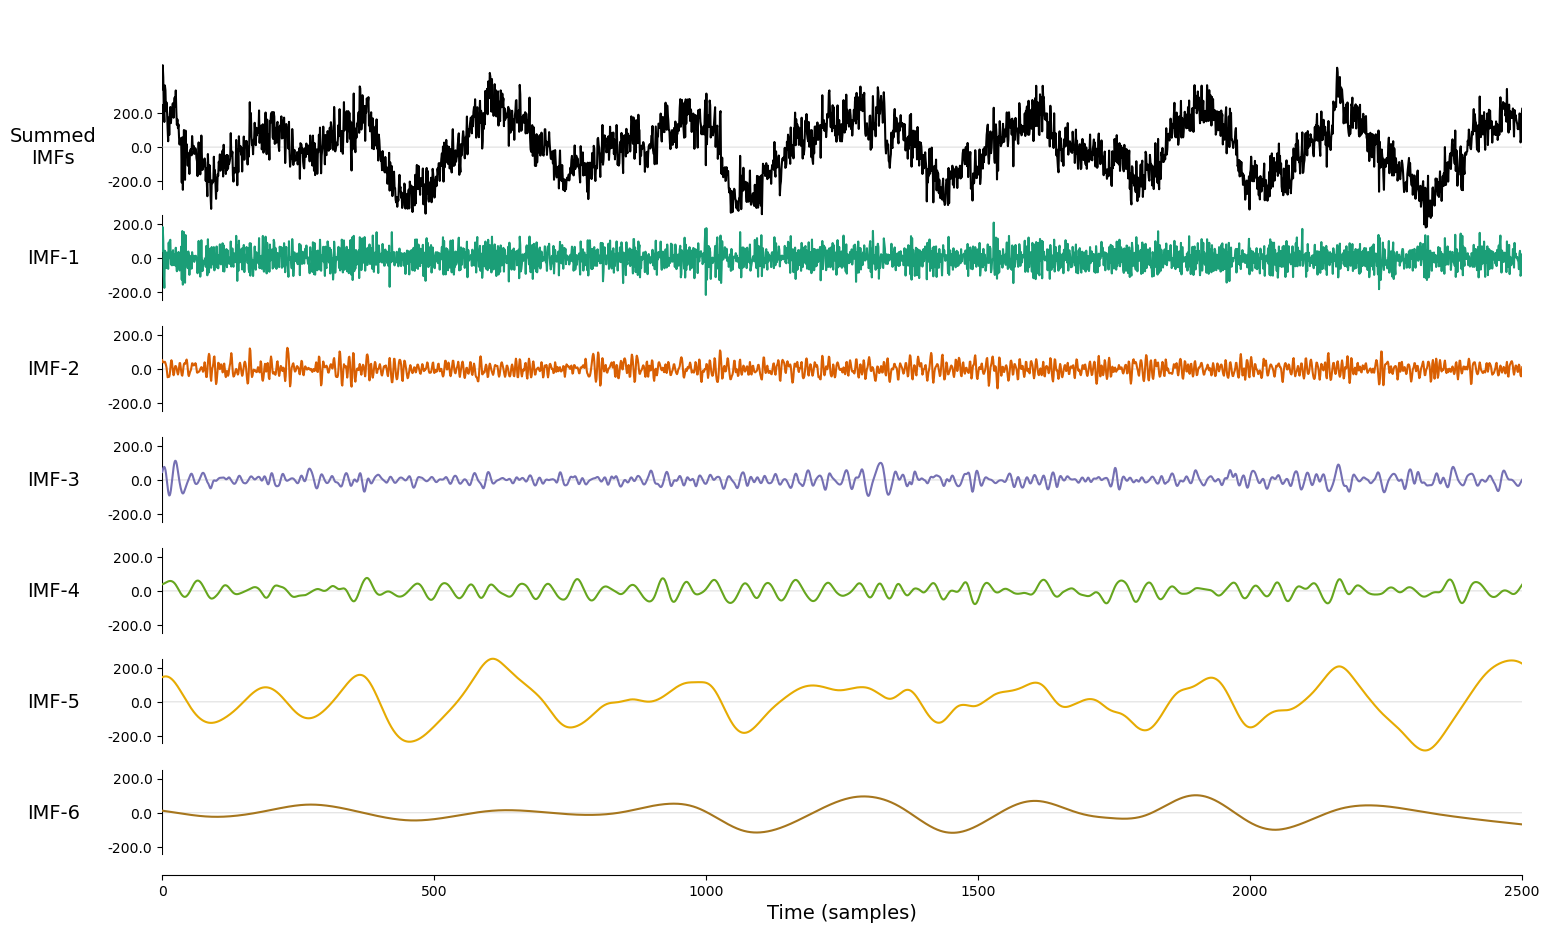

In [33]:
ensimf = emd.sift.ensemble_sift(first_rem, max_imfs=6,nensembles =4, nprocesses=6,ensemble_noise = 1)
ensimfig_4 = emd.plotting.plot_imfs(ensimf[:2500]).get_figure()

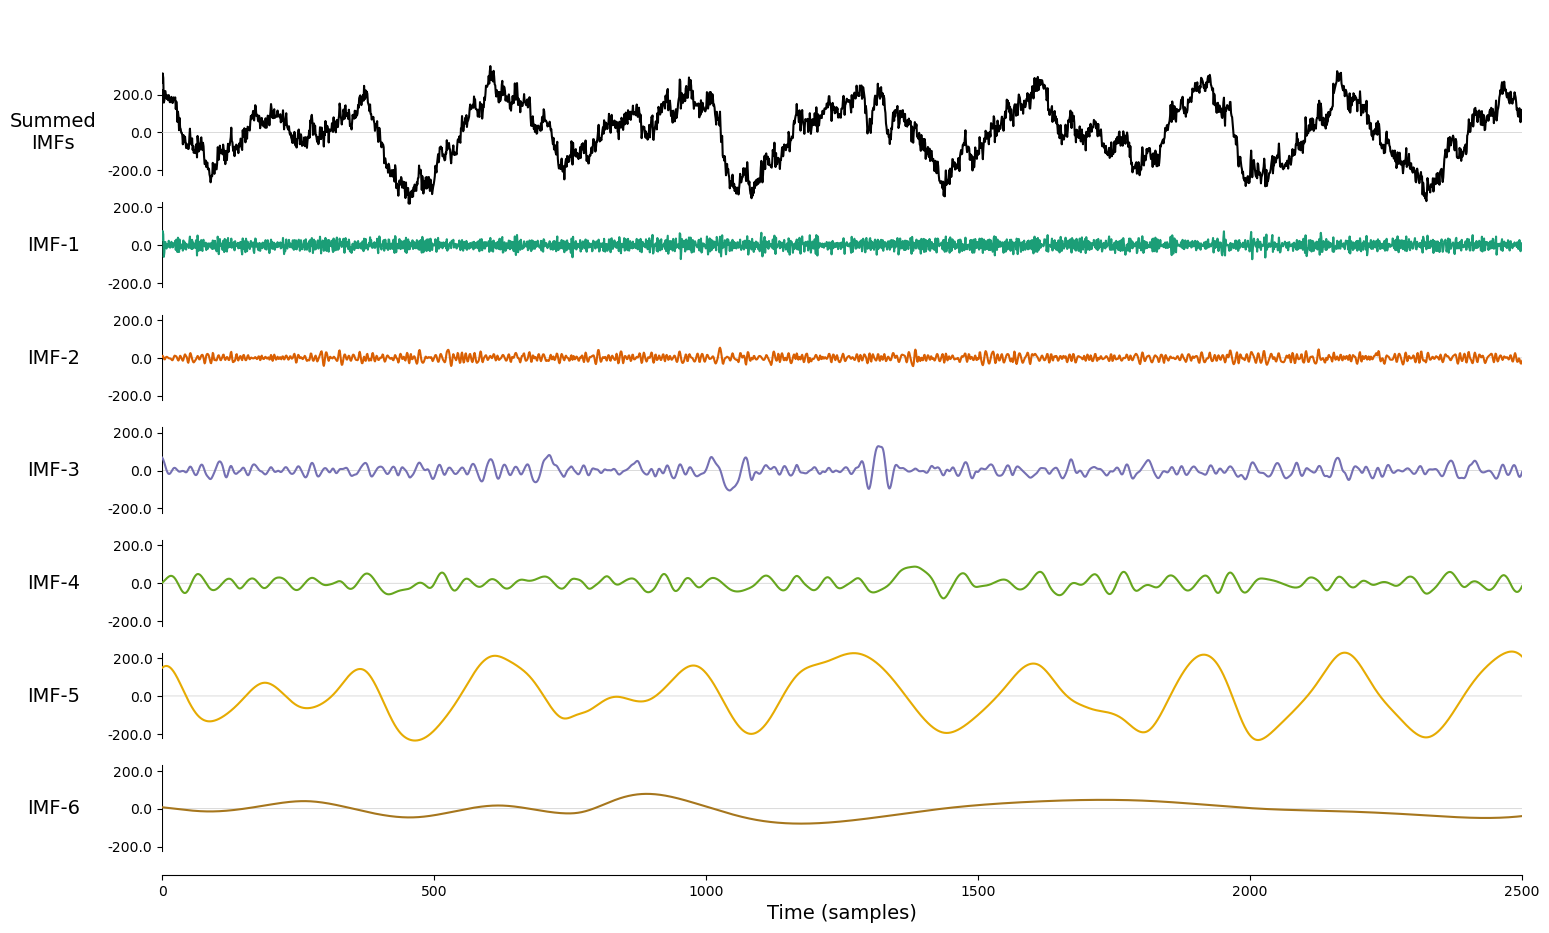

In [38]:
ensimf = emd.sift.ensemble_sift(first_rem, max_imfs=6,nensembles =2, nprocesses=6,ensemble_noise = 0.2)
ensimfig_24 = emd.plotting.plot_imfs(ensimf[:2500]).get_figure()

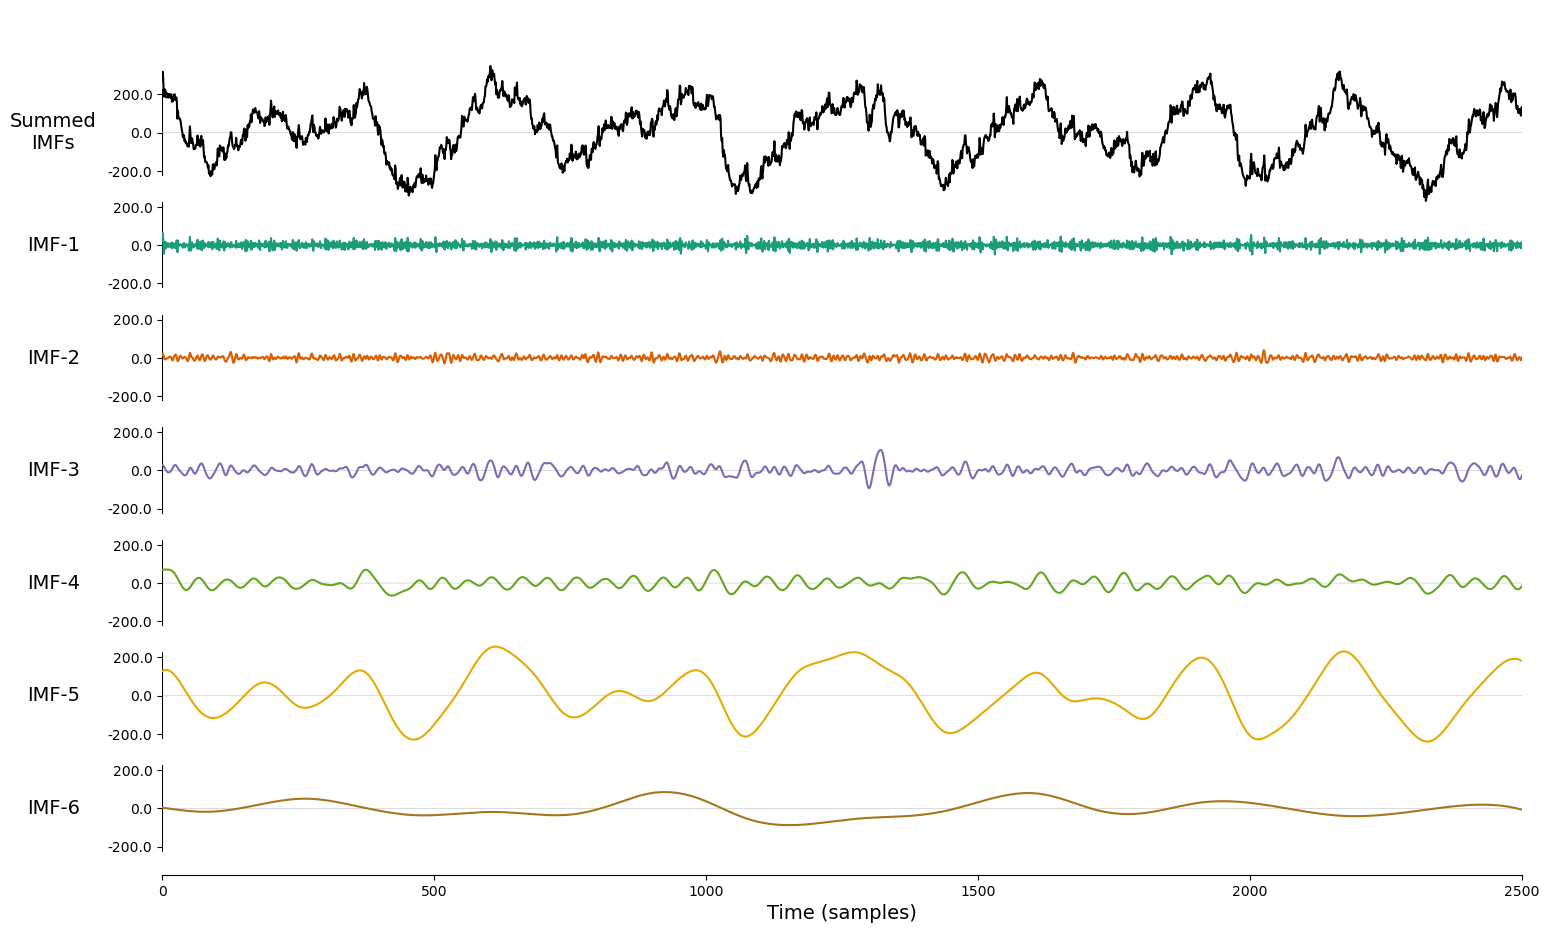

In [40]:
ensimf = emd.sift.ensemble_sift(first_rem, max_imfs=6,nensembles =200, nprocesses=6,ensemble_noise = 0.2)
ensimfig_24 = emd.plotting.plot_imfs(ensimf[:2500]).get_figure()

Complete Ensemble Sift


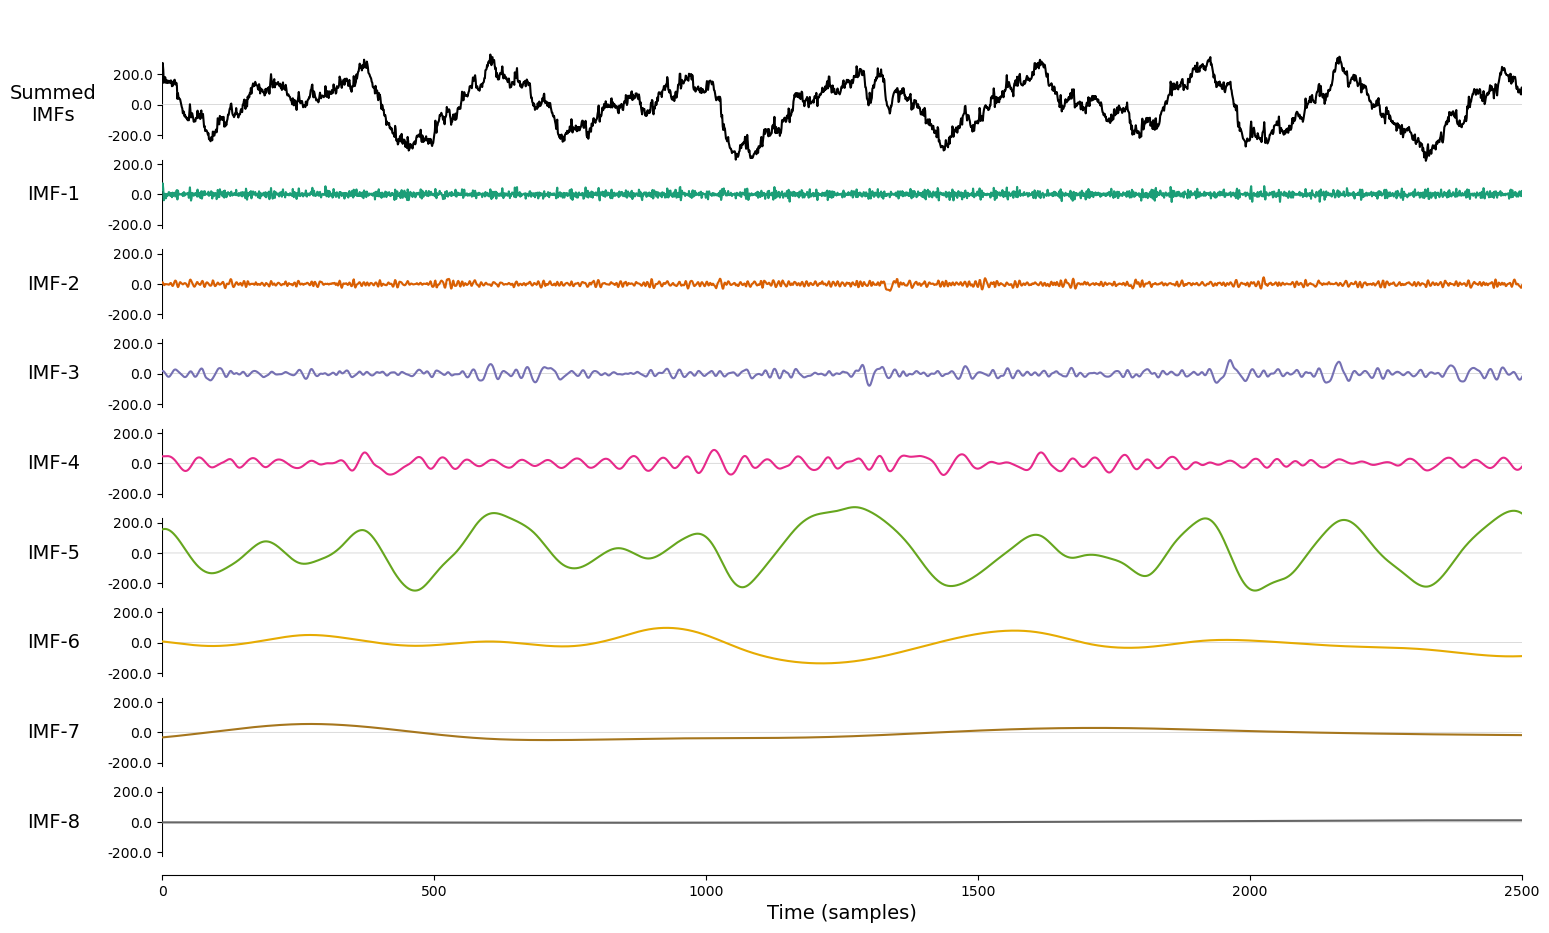

In [39]:
print('Complete Ensemble Sift')

censemble=emd.sift.complete_ensemble_sift(first_rem, max_imfs=6)
censemblefig=emd.plotting.plot_imfs(censemble[:2500,:]).get_figure()


Masked Sift Zero Cross Setting


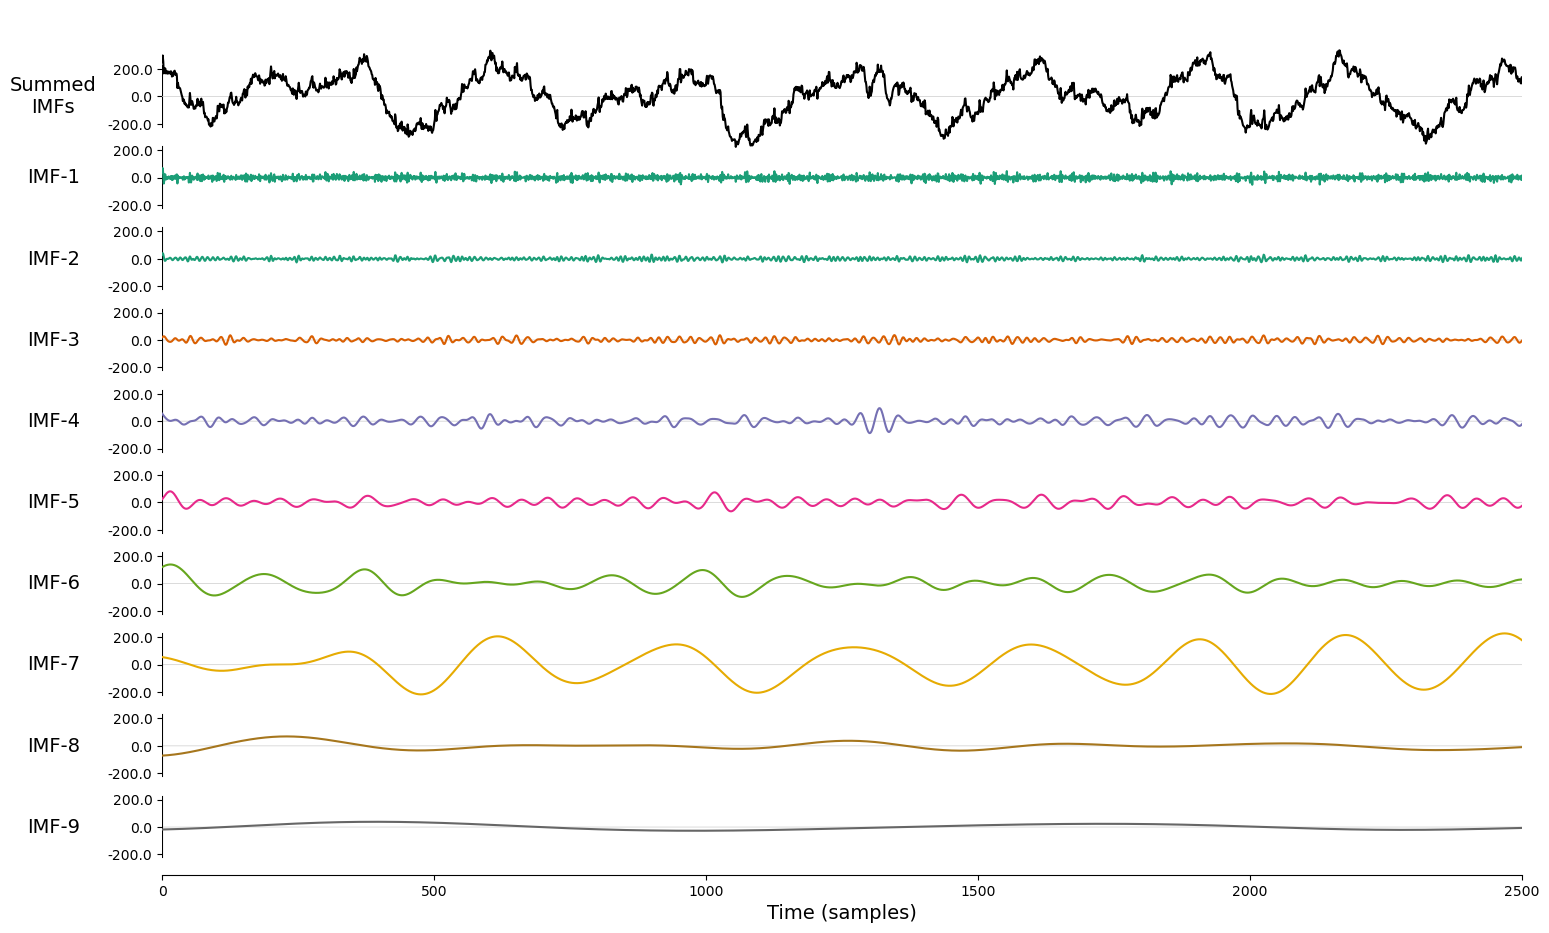

In [41]:
print('Masked Sift Zero Cross Setting')

maskzc=emd.sift.mask_sift(first_rem,mask_freqs='zc',ret_mask_freq='True')
maskzcfig=emd.plotting.plot_imfs(maskzc[0][:2500,:]).get_figure()

In [48]:
len(lfp)/s_rate

10801.6984

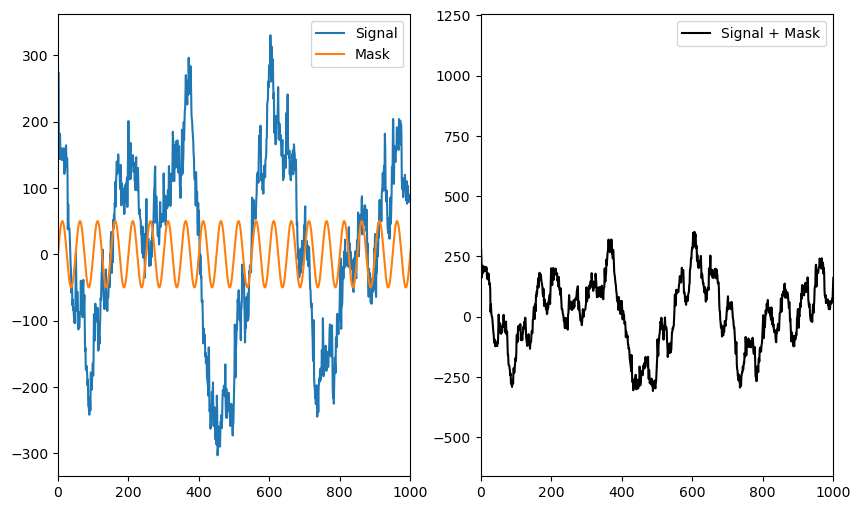

In [70]:
time=len(first_rem)/s_rate
seconds=np.linspace(0,time,len(first_rem))

mask = 50*np.sin(2*np.pi*50*seconds)

plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(first_rem[:1000])
plt.plot(mask)
plt.legend(['Signal', 'Mask'])
plt.xlim(0, 1000)
plt.subplot(122)
plt.plot(first_rem + mask, color='k')
plt.xlim(0, 1000)
plt.legend(['Signal + Mask'])

In [71]:
imf_raw, _ = emd.sift.get_next_imf(first_rem)
imf_mask, _ = emd.sift.get_next_imf(first_rem+mask)

Text(0.5, 1.0, 'Masked IMF with Mask removed')

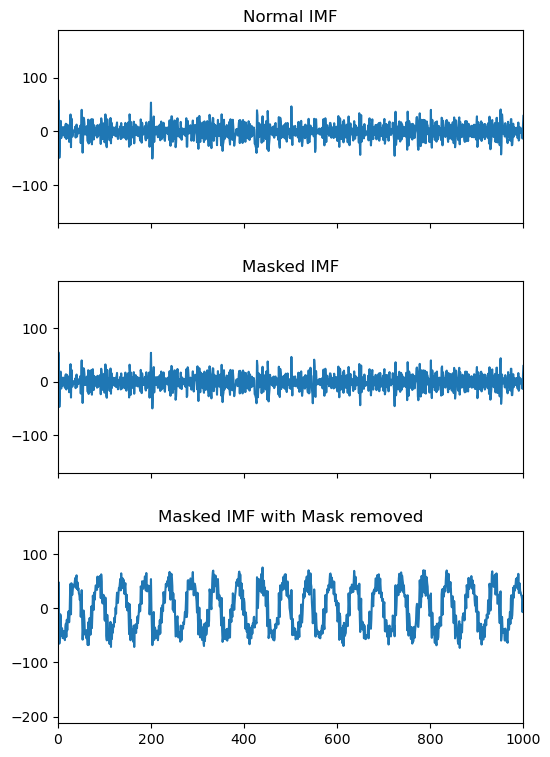

In [72]:
plt.figure(figsize=(6,9))
plt.subplots_adjust(hspace=0.3)
plt.subplot(311)
plt.plot(imf_raw)
plt.xlim(0, 1000)
plt.title('Normal IMF')
plt.gca().set_xticklabels([])
plt.subplot(312)
plt.plot(imf_mask)
plt.xlim(0, 1000)
plt.title('Masked IMF')
plt.gca().set_xticklabels([])
plt.subplot(313)
plt.plot(imf_mask - mask[:, np.newaxis])
plt.xlim(0, 1000)
plt.title('Masked IMF with Mask removed')

Iterated Masked Sift Zero Cross Setting


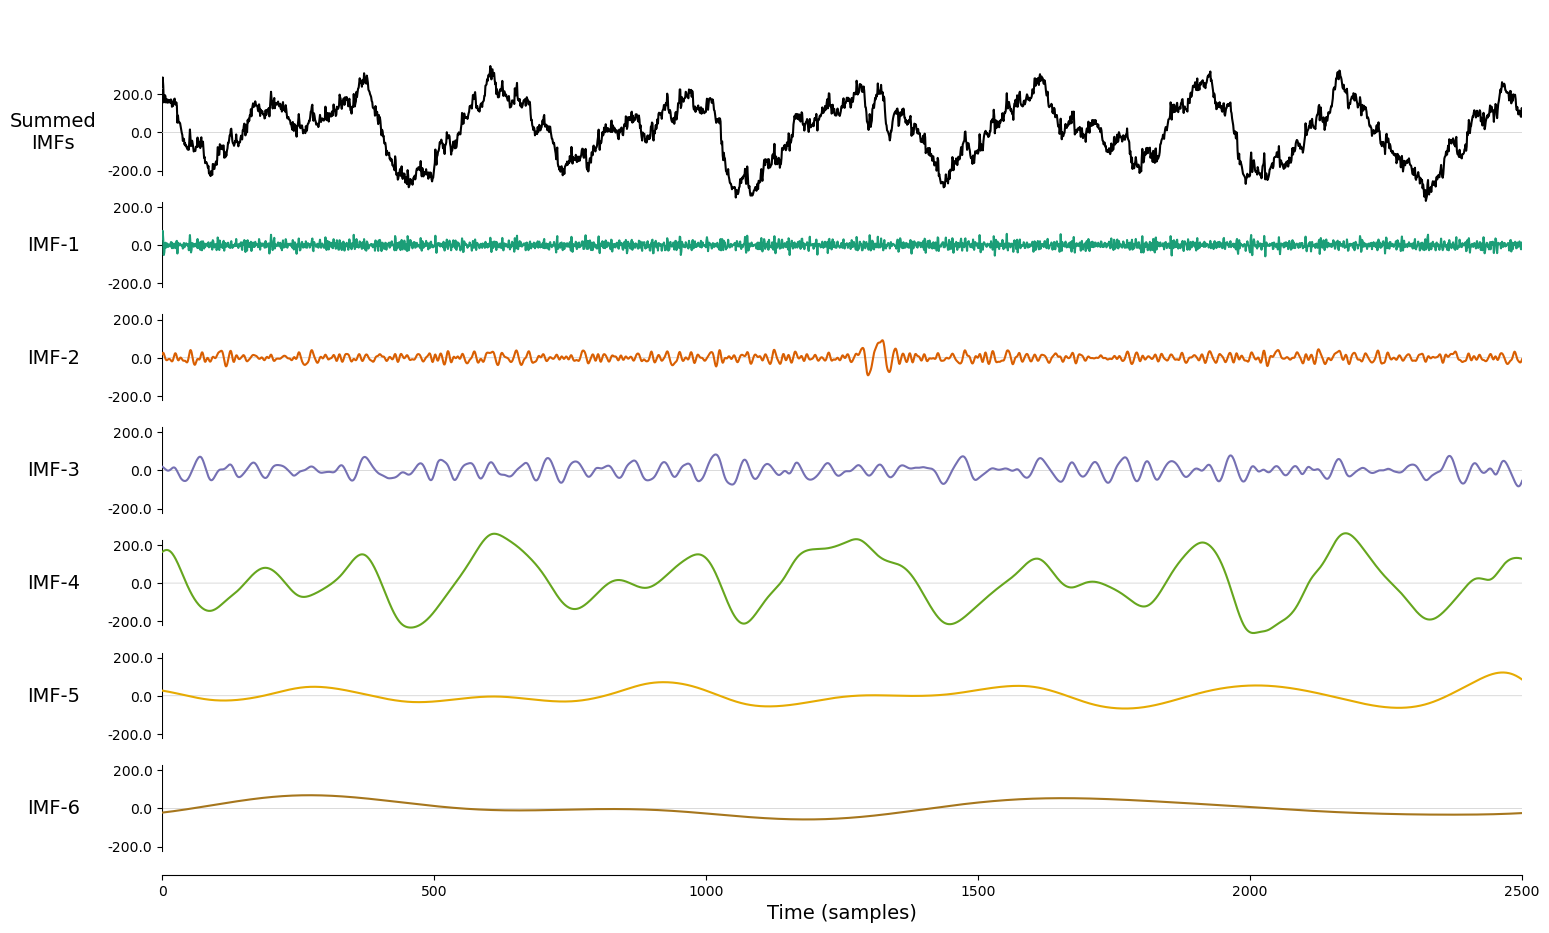

In [60]:
print('Iterated Masked Sift Zero Cross Setting')

imask=emd.sift.iterated_mask_sift(first_rem,mask_0='zc',sample_rate=s_rate,ret_mask_freq='True')
imaskzcfig=emd.plotting.plot_imfs(imask[0][:2500,:]).get_figure()

Masked Sift Instantaneous Frequency Setting


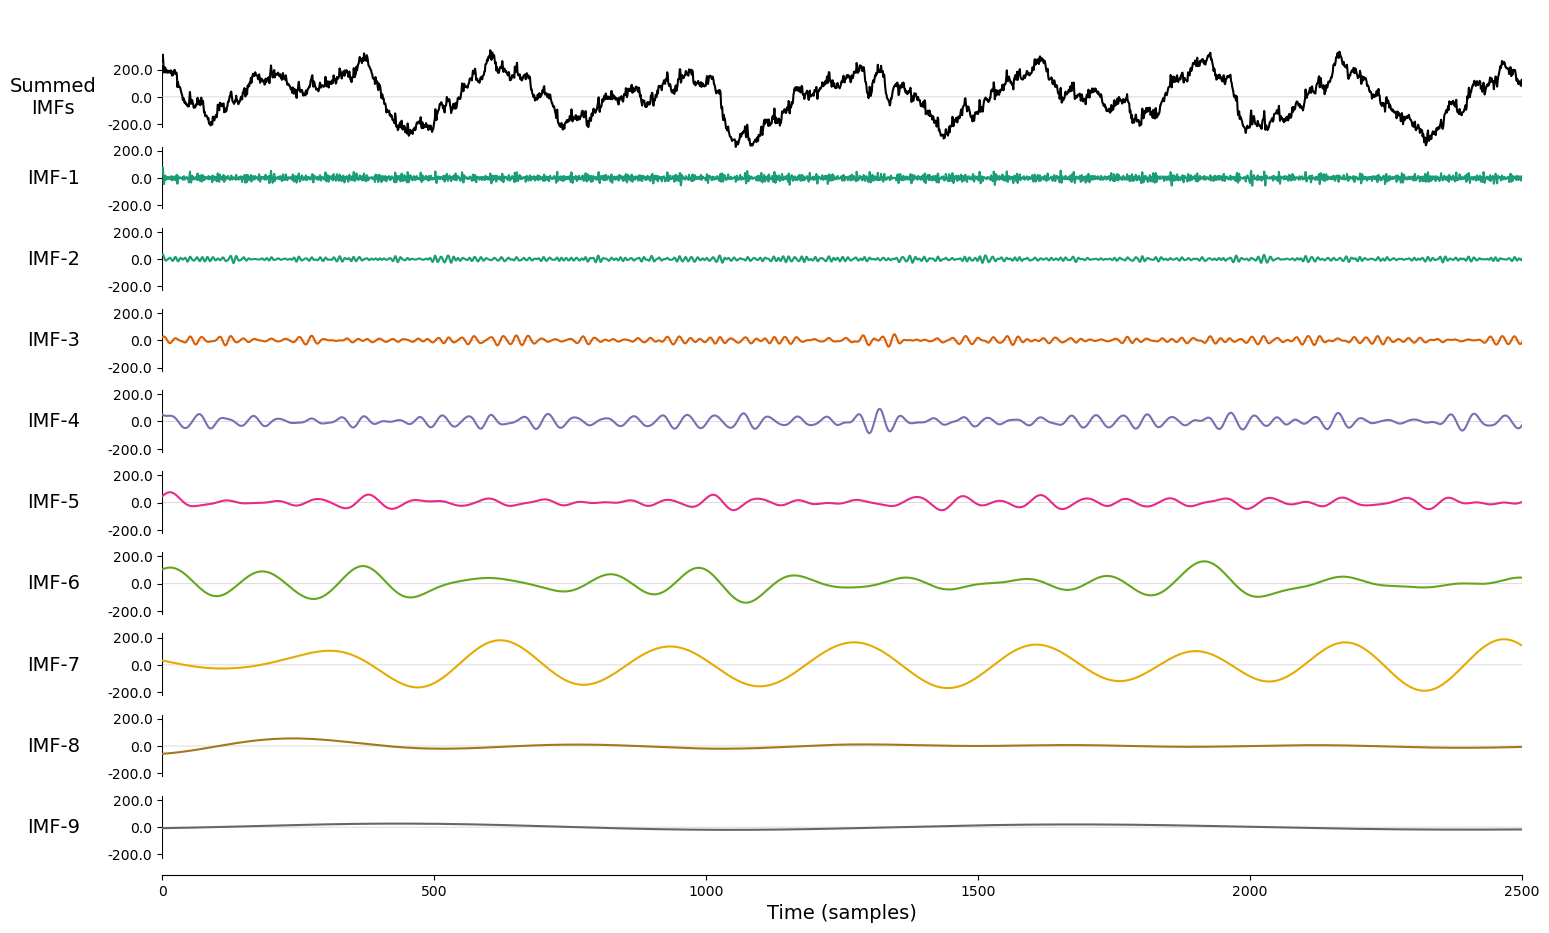

In [61]:
print('Masked Sift Instantaneous Frequency Setting')

maskif=emd.sift.mask_sift(first_rem,mask_freqs='if',ret_mask_freq='True')
maskiffig=emd.plotting.plot_imfs(maskif[0][:2500,:]).get_figure()

Masked Sift 50 Hz


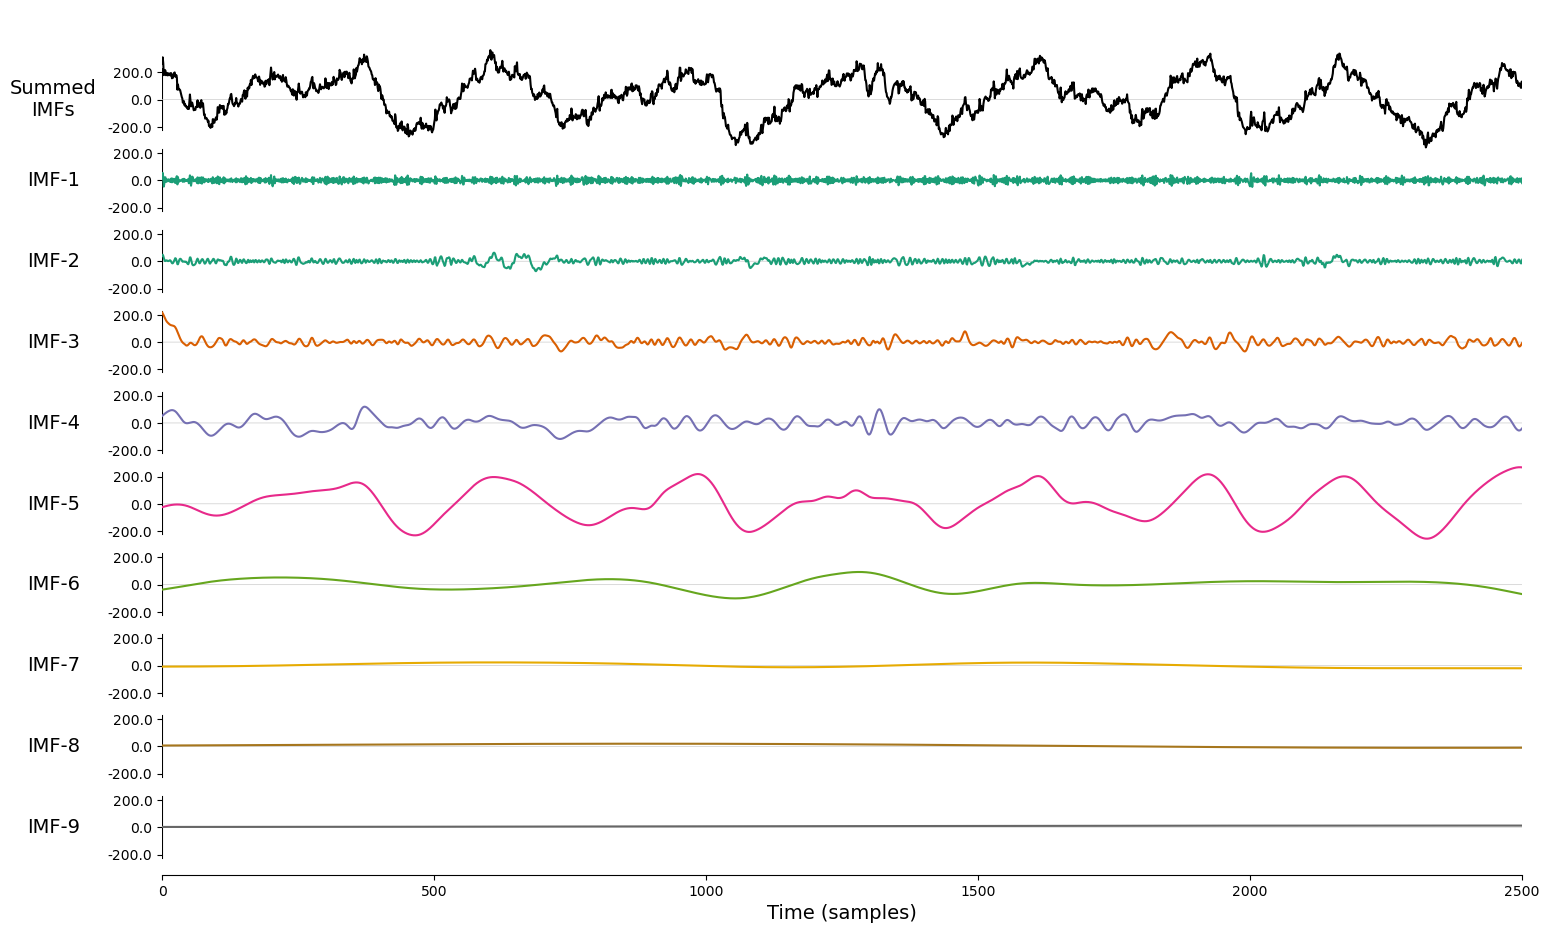

In [74]:
print('Masked Sift 120 Hz')

maskzc=emd.sift.mask_sift(first_rem,mask_freqs= 120/s_rate,ret_mask_freq='True')
maskzcfig=emd.plotting.plot_imfs(maskzc[0][:2500,:]).get_figure()

Masked Sift 60 Hz


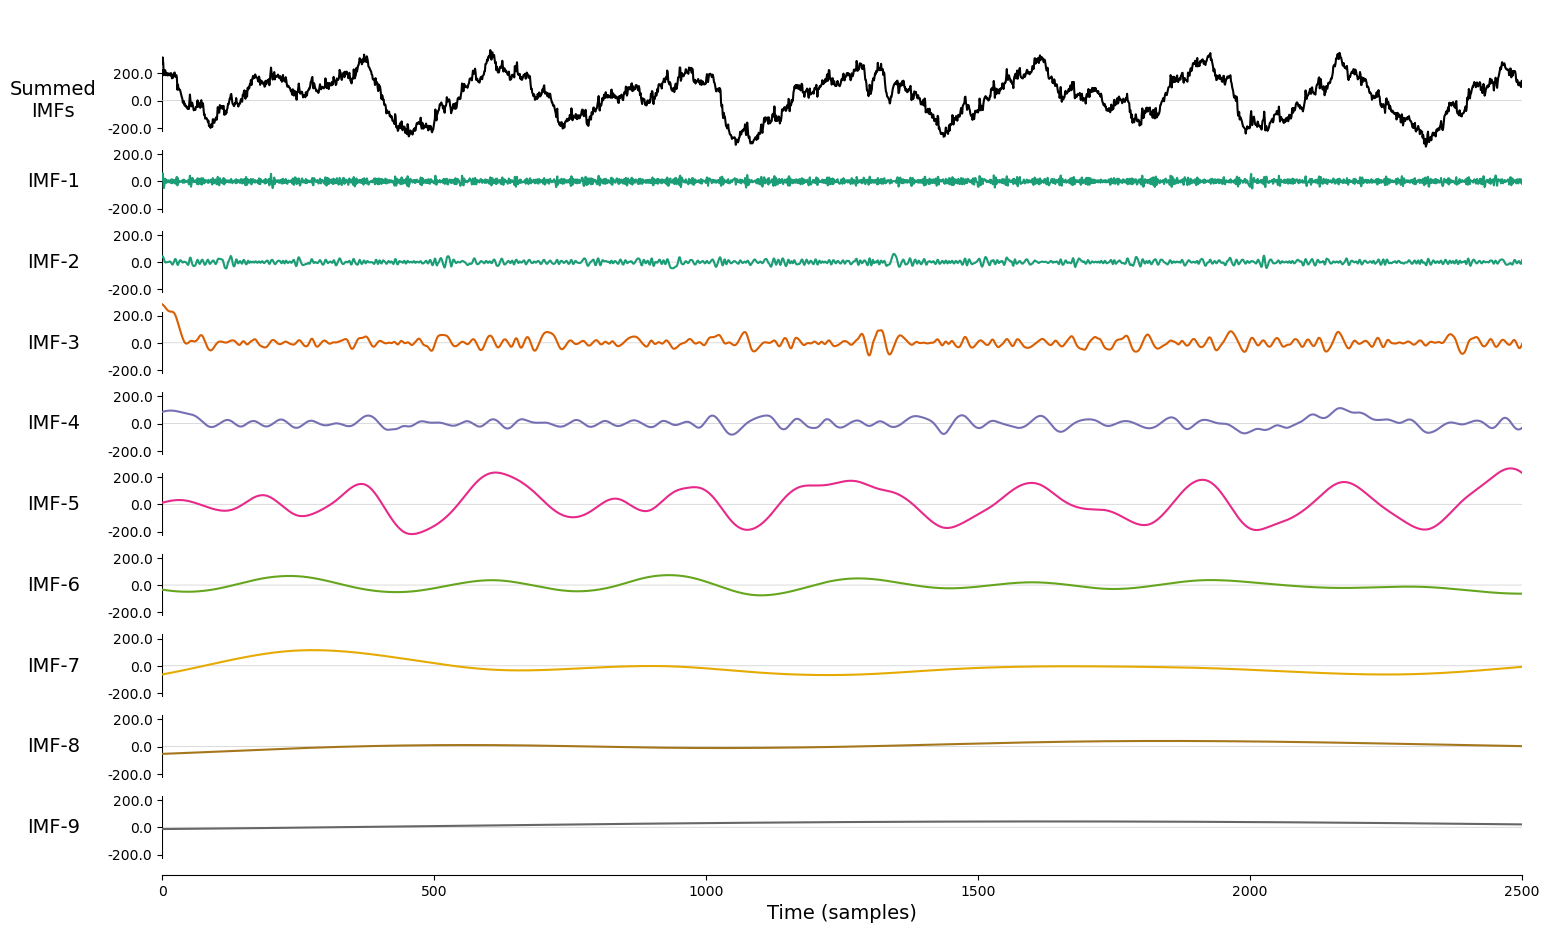

In [75]:
print('Masked Sift 60 Hz')

maskzc=emd.sift.mask_sift(first_rem,mask_freqs= 60/s_rate,ret_mask_freq='True')
maskzcfig=emd.plotting.plot_imfs(maskzc[0][:2500,:]).get_figure()

Masked Sift 30 Hz


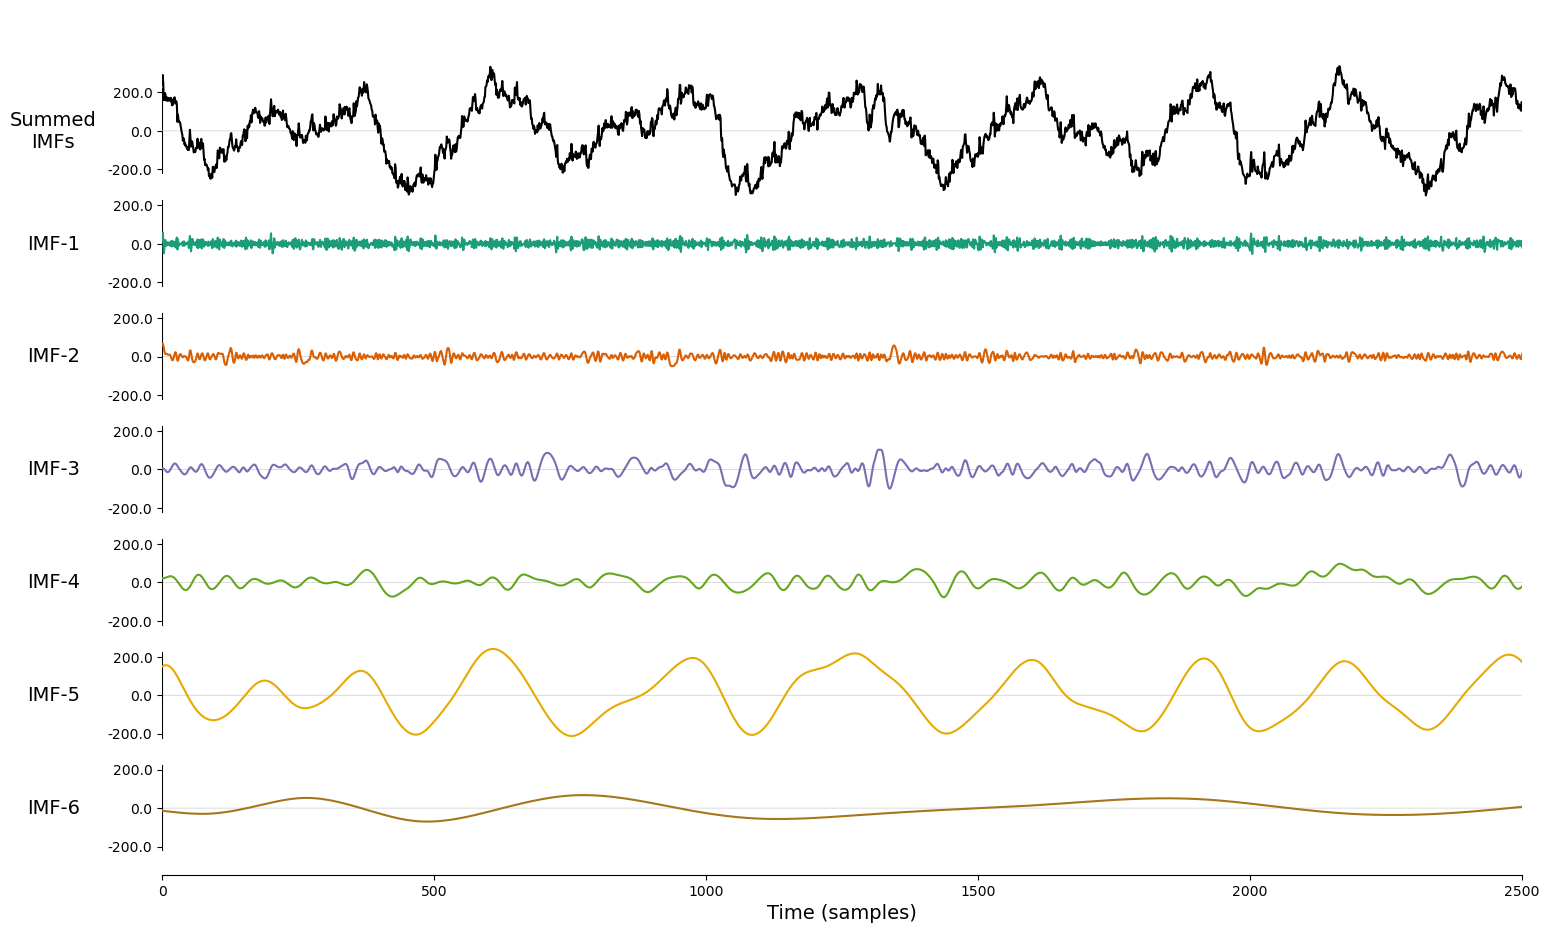

In [85]:
print('Masked Sift 30 Hz')

maskzc=emd.sift.mask_sift(first_rem,max_imfs=6,mask_freqs= 30/s_rate,ret_mask_freq='False')
maskzcfig=emd.plotting.plot_imfs(maskzc[0][:2500,:]).get_figure()

In [87]:
imf = emd.sift.mask_sift(first_rem,max_imfs=6)

IP,IF,IA = emd.spectra.frequency_transform(imf, s_rate, 'nht')
print(np.average(IF, 0, weights=IA**2))

[632.1282912  296.10128195 137.20368366  63.32375132  39.86317697
  16.19915593]


<Axes: xlabel='Time (samples)'>

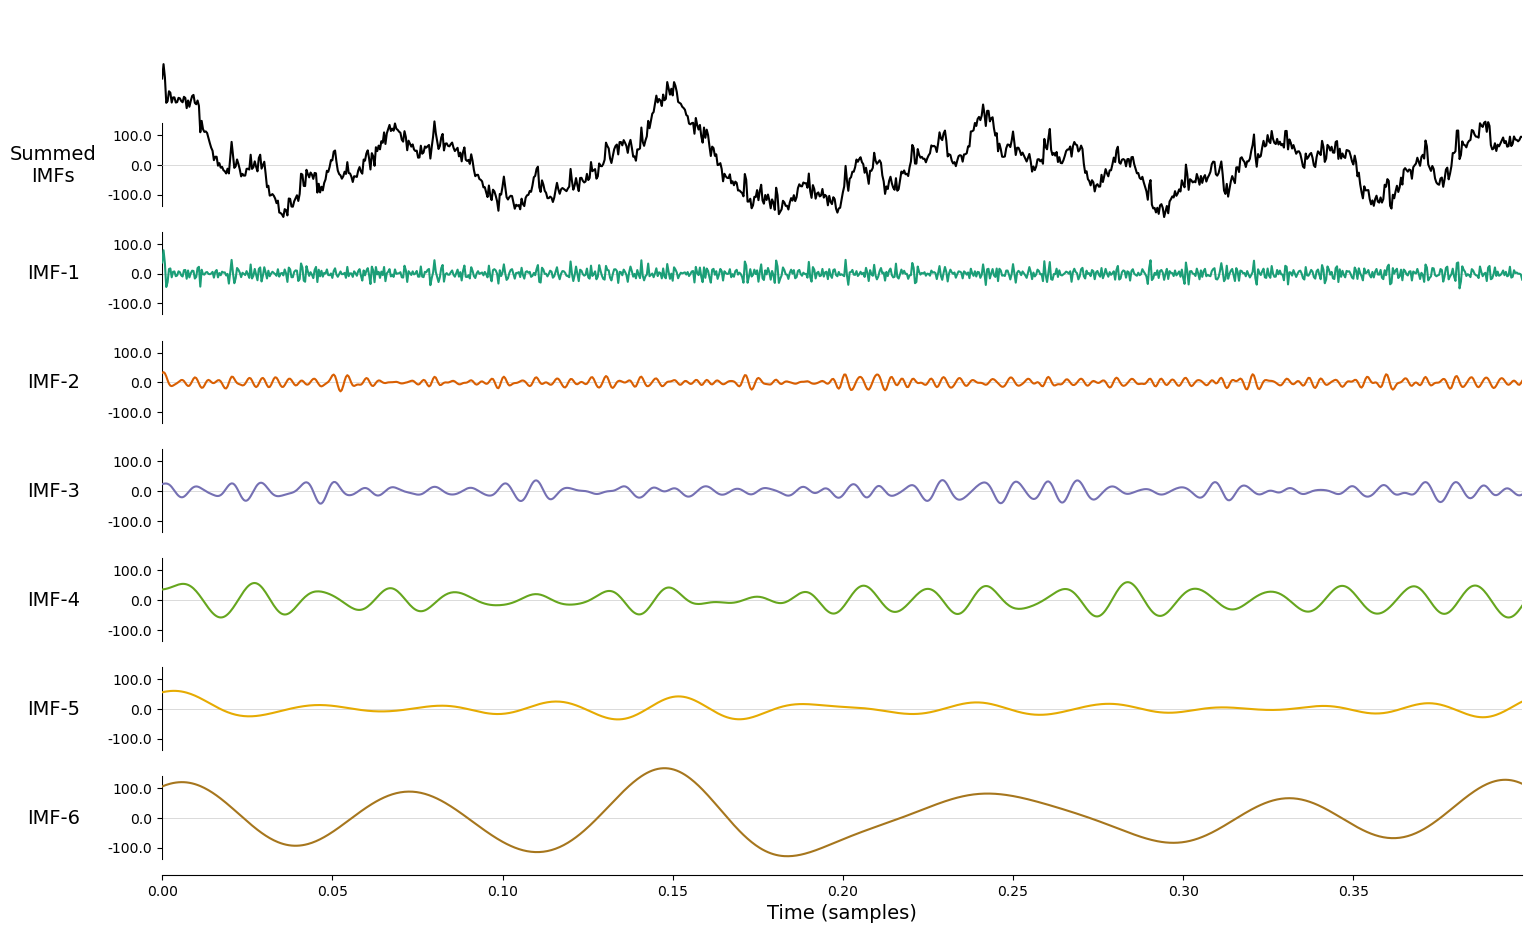

In [95]:
mask_1 = np.average(IF, 0, weights=IA**2) / s_rate
imf = emd.sift.mask_sift(first_rem, max_imfs=6, mask_freqs=mask_1)
emd.plotting.plot_imfs(imf[:1000], time_vect=seconds[:1000])

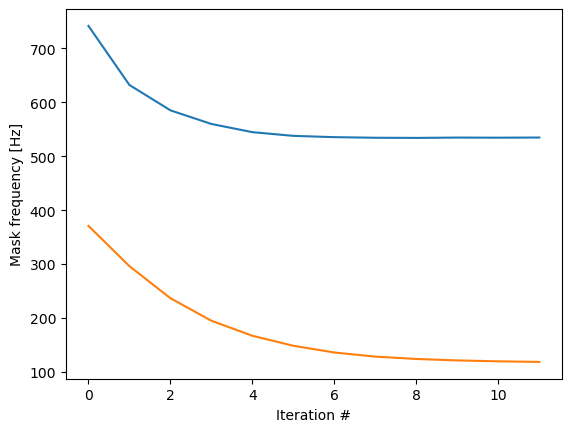

In [99]:
imf, mask_0 = emd.sift.mask_sift(first_rem, max_imfs=6, ret_mask_freq=True)

# Take the mean IF as new mask, compute mask sift again and plot
IP,IF,IA = emd.spectra.frequency_transform(imf, s_rate, 'nht')
mask = np.average(IF, 0, weights=IA**2) / s_rate

# Save all masks:
mask_all = np.zeros((3, 12))
mask_all[:, 0] = mask_0[:3]
mask_all[:, 1] = mask[:3]

for i in range(10):
    imf = emd.sift.mask_sift(first_rem, max_imfs=6, mask_freqs=mask)
    IP,IF,IA = emd.spectra.frequency_transform(imf, s_rate, 'nht')
    mask = np.average(IF, 0, weights=IA**2) / s_rate
    mask_all[:, i+2] = mask[:3]

plt.figure()
for i in range(2):
    plt.plot(mask_all[i, :]*s_rate)
plt.xlabel('Iteration #')
plt.ylabel('Mask frequency [Hz]')
plt.show()

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

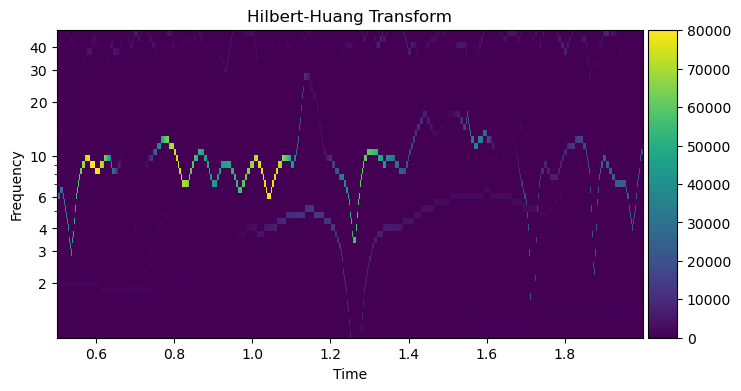

In [103]:
IP, IF, IA = emd.spectra.frequency_transform(imf, s_rate, 'nht')
f, hht = emd.spectra.hilberthuang(IF, IA, (1, 50, 49, 'log'), sum_time=False)

plt.figure(figsize=(8,4))
ax = plt.subplot(111)
emd.plotting.plot_hilberthuang(hht, seconds, f,
                               log_y=True, cmap='viridis',
                               ax=ax, time_lims=(0.5, 2))

In [107]:
def imf_freq(imf,sample_rate,mode='nht'):
  _,IF,_=emd.spectra.frequency_transform(imf,sample_rate,'nht')
  freq_vec=np.mean(IF,axis=0)
  return freq_vec

In [123]:
sift=emd.sift.sift(first_rem)

ensemble=emd.sift.ensemble_sift(first_rem)

censemble=emd.sift.complete_ensemble_sift(first_rem, max_imfs=6)
maskif=emd.sift.mask_sift(first_rem,mask_freqs='if',ret_mask_freq='True')
imask=emd.sift.iterated_mask_sift(first_rem,mask_0='zc',sample_rate=s_rate,ret_mask_freq='True')
maskzc=emd.sift.mask_sift(first_rem,mask_freqs='zc',ret_mask_freq='True')
sift_mask_freq=imf_freq(sift,s_rate)
print(f'{sift_mask_freq} in Hz')

[6.12550535e+02 2.91034586e+02 9.58301671e+01 3.86620446e+01
 1.19059934e+01 5.10818806e+00 2.20086307e+00 9.73856145e-01
 4.53088839e-01 1.92662481e-01 4.99966693e-02] in Hz


In [209]:
#Defining Gamma Split

def tg_split(mask_freq, gamma_range=(30, 120)):
    """
        Split a frequency vector into sub-gamma, gamma, and supra-gamma components.

        Parameters:
        mask_freq (numpy.ndarray): A frequency vector or array of frequency values.
        gamma_range (tuple, optional): A tuple defining the gamma frequency range (lower, upper).
            Default is (5, 12).

        Returns:
        tuple: A tuple containing boolean masks for sub-gamma, gamma, and supra-gamma frequency components.

        Notes: - This function splits a frequency mask into three components based on a specified gamma frequency
        range. - The gamma frequency range is defined by the 'gamma_range' parameter. - The resulting masks 'sub',
        'gamma', and 'supra' represent sub-gamma, gamma, and supra-gamma frequency components.
    """
    lower = np.min(gamma_range)
    upper = np.max(gamma_range)
    mask_index = np.logical_and(mask_freq >= lower, mask_freq < upper)
    sub_mask_index = mask_freq < lower
    supra_mask_index = mask_freq > upper
    sub = sub_mask_index
    gamma = mask_index
    supra = supra_mask_index

    return sub, gamma, supra

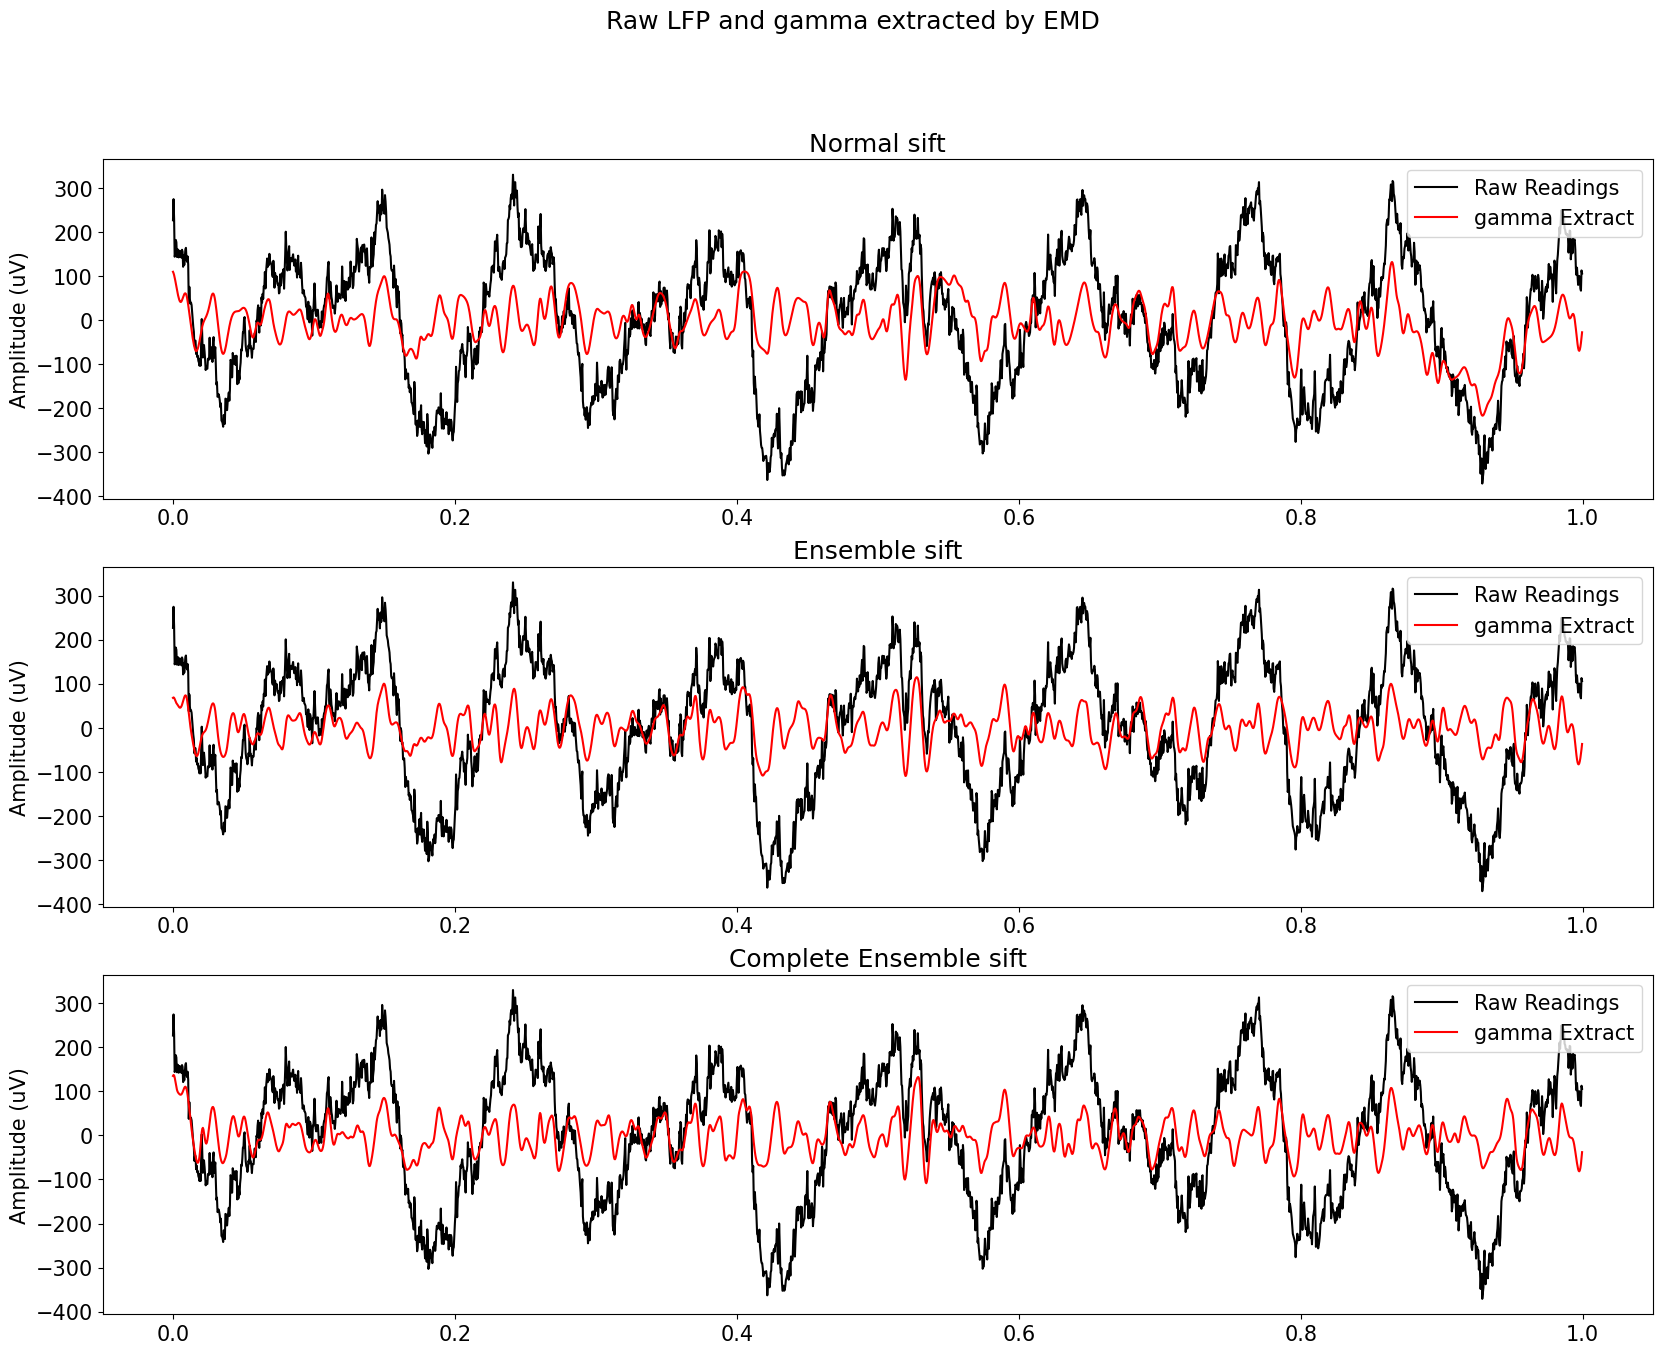

In [210]:
# Loop through each REM state to plot the results for each sift method
fig1, ax1 = plt.subplots(3, figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

time = len(first_rem) / s_rate
seconds = np.linspace(0, time, len(first_rem))
# Normal sift
sift_mask_freq = imf_freq(sift, s_rate)
_, sift_gamma, _ = tg_split(sift_mask_freq)
sift_gammasig = np.sum(sift.T[sift_gamma], axis=0)
ax1[0].plot(seconds[:2500], first_rem[:2500], '-k', label='Raw Readings')
ax1[0].plot(seconds[:2500], sift_gammasig[:2500], '-r', label='gamma Extract')
ax1[0].legend(loc="upper right")
ax1[0].set_ylabel('Amplitude (uV)')
ax1[0].set_title('Normal sift')

# Ensemble sift
ensemble_mask_freq = imf_freq(ensemble, s_rate)
_, ensemble_gamma, _ = tg_split(ensemble_mask_freq)
ensemble_gammasig = np.sum(ensemble.T[ensemble_gamma], axis=0)
ax1[1].plot(seconds[:2500], first_rem[:2500], '-k', label='Raw Readings')
ax1[1].plot(seconds[:2500], ensemble_gammasig[:2500], '-r', label='gamma Extract')
ax1[1].legend(loc="upper right")
ax1[1].set_ylabel('Amplitude (uV)')
ax1[1].set_title('Ensemble sift')

# Complete Ensemble sift
censemble_mask_freq = imf_freq(censemble, s_rate)
_, censemble_gamma, _ = tg_split(censemble_mask_freq)
censemble_gammasig = np.sum(censemble.T[censemble_gamma], axis=0)
ax1[2].plot(seconds[:2500], first_rem[:2500], '-k', label='Raw Readings')
ax1[2].plot(seconds[:2500], censemble_gammasig[:2500], '-r', label='gamma Extract')
ax1[2].legend(loc="upper right")
ax1[2].set_ylabel('Amplitude (uV)')
ax1[2].set_title('Complete Ensemble sift')

titlee = 'Raw LFP and gamma extracted by EMD'
fig1.suptitle(titlee)
plt.show()  # Display the plots for the current REM state
     

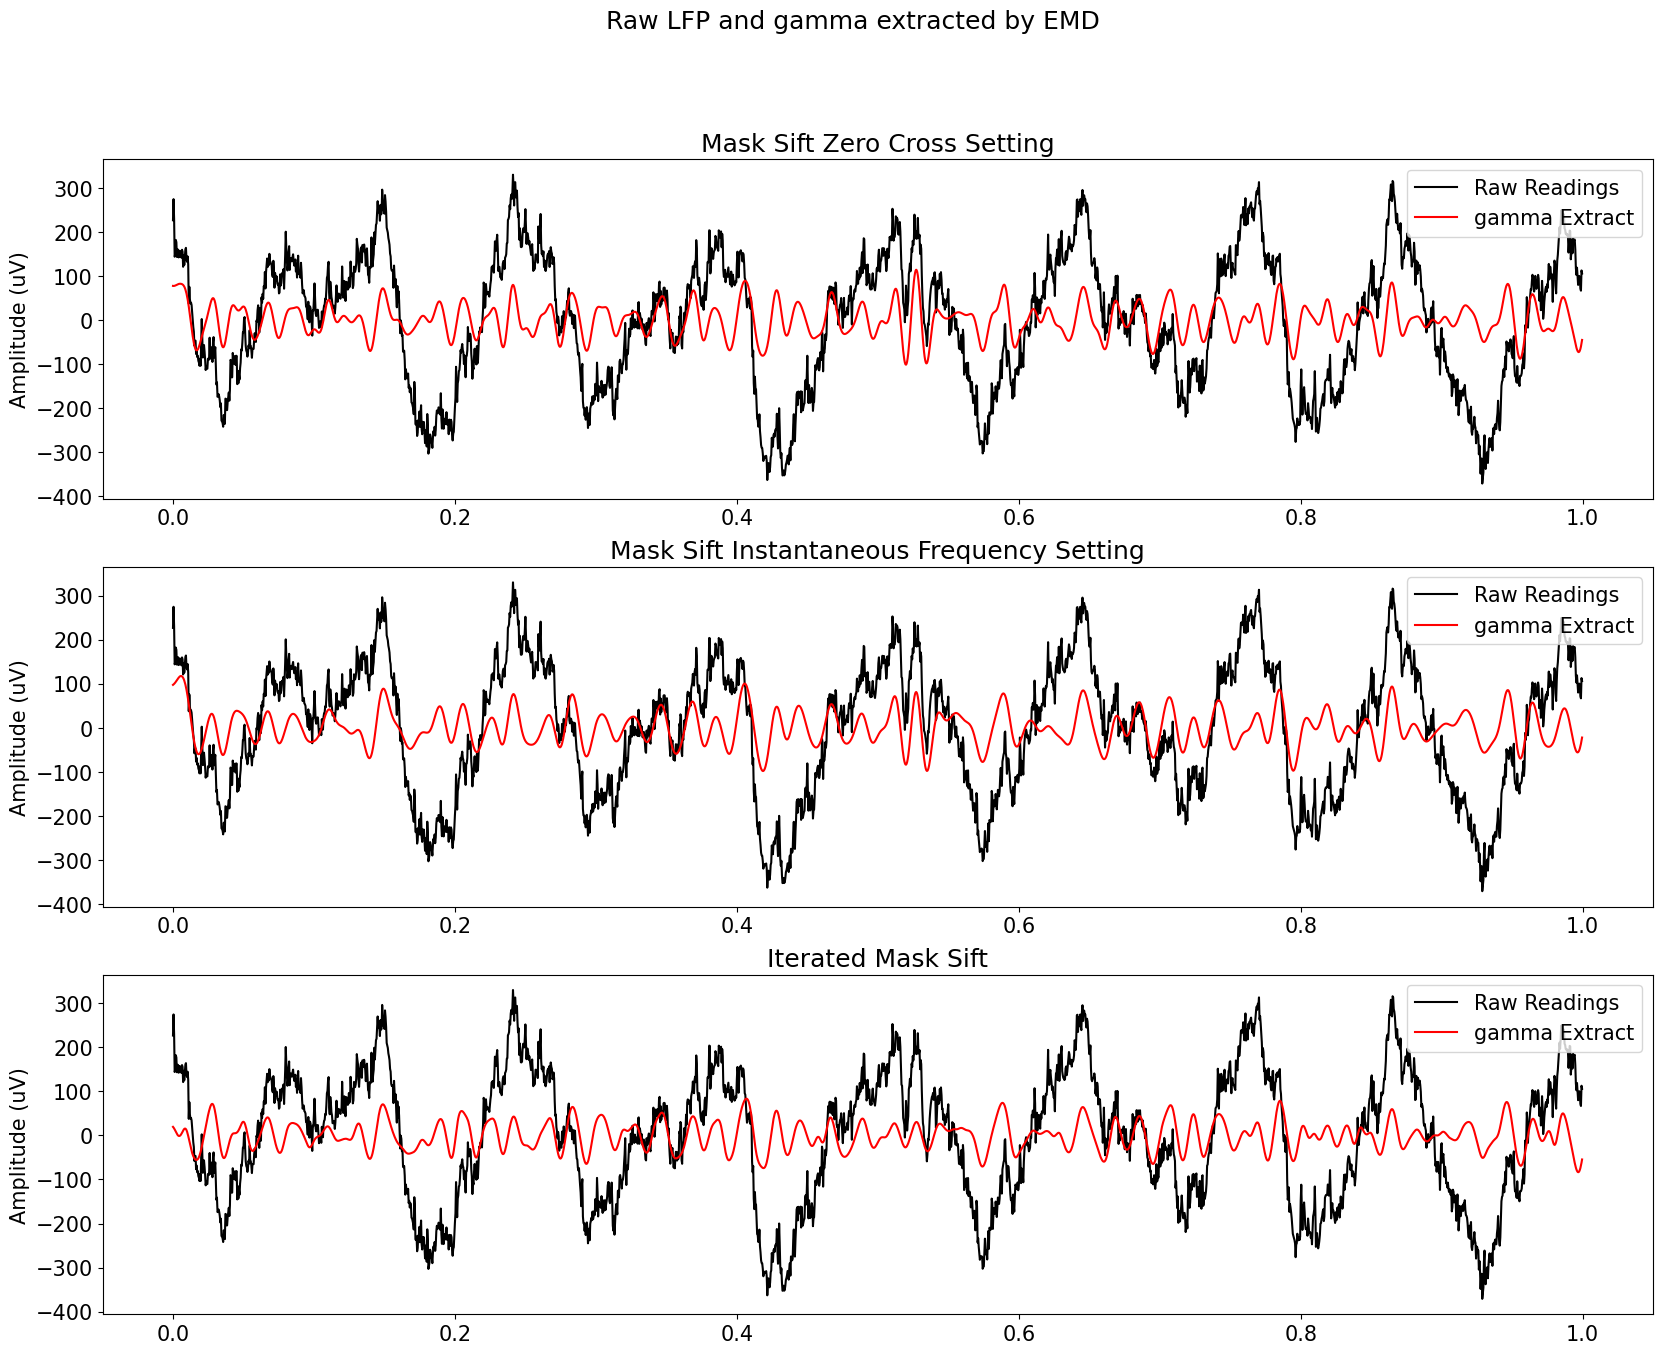

In [211]:
fig2, ax2 = plt.subplots(3, figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

time = len(first_rem) / s_rate
seconds = np.linspace(0, time, len(first_rem))

# Mask Sift Zero Cross Setting
_, maskzc_gamma, _ = tg_split(maskzc[1] * s_rate)
maskzc_gammasig = np.sum(maskzc[0].T[maskzc_gamma], axis=0)
ax2[0].plot(seconds[:2500], first_rem[:2500], '-k', label='Raw Readings')
ax2[0].plot(seconds[:2500], maskzc_gammasig[:2500], '-r', label='gamma Extract')
ax2[0].legend(loc="upper right")
ax2[0].set_ylabel('Amplitude (uV)')
ax2[0].set_title('Mask Sift Zero Cross Setting')

# Mask Sift Instantaneous Frequency Setting
_, maskif_gamma, _ = tg_split(maskif[1] * s_rate)
maskif_gammasig = np.sum(maskif[0].T[maskif_gamma], axis=0)
ax2[1].plot(seconds[:2500], first_rem[:2500], '-k', label='Raw Readings')
ax2[1].plot(seconds[:2500], maskif_gammasig[:2500], '-r', label='gamma Extract')
ax2[1].legend(loc="upper right")
ax2[1].set_ylabel('Amplitude (uV)')
ax2[1].set_title('Mask Sift Instantaneous Frequency Setting')

# Iterated Mask Sift
_, imask_gamma, _ = tg_split(imask[1])
imask_gammasig = np.sum(imask[0].T[imask_gamma], axis=0)
ax2[2].plot(seconds[:2500], first_rem[:2500], '-k', label='Raw Readings')
ax2[2].plot(seconds[:2500], imask_gammasig[:2500], '-r', label='gamma Extract')
ax2[2].legend(loc="upper right")
ax2[2].set_ylabel('Amplitude (uV)')
ax2[2].set_title('Iterated Mask Sift')

titlee = 'Raw LFP and gamma extracted by EMD'
fig2.suptitle(titlee)
plt.show()  # Display the plots for the current REM state
    

In [212]:
sub_gamma, gamma, supra_gamma = tg_split(imask[1])
gamma_sig=np.sum(imask[0].T[gamma],axis=0)
supra_gamma_sig=np.sum(imask[0].T[supra_gamma],axis=0)
sub_gamma_sig= np.sum(imask[0].T[sub_gamma],axis=0)

In [213]:
imask=emd.sift.iterated_mask_sift(first_rem,mask_0='zc',sample_rate=s_rate,ret_mask_freq='True')

# Extract the gamma signal
sub_gamma, gamma, supra_gamma = tg_split(imask[1])
gamma_sig=np.sum(imask[0].T[gamma],axis=0)
supra_gamma_sig=np.sum(imask[0].T[supra_gamma],axis=0)
sub_gamma_sig= np.sum(imask[0].T[sub_gamma],axis=0)

In [214]:
import sails

frequencies= np.arange(15,141,1)
gamma_range=(30,120)
time=len(first_rem)/s_rate
seconds=np.linspace(0,time,len(first_rem))

first_rem_wt= sails.wavelet.morlet(first_rem, freqs=frequencies, sample_rate=s_rate, ncycles=5,ret_mode='power', normalise=None)
gamma_wt= sails.wavelet.morlet(gamma_sig, freqs=frequencies, sample_rate=s_rate, ncycles=5,ret_mode='power', normalise=None)
supra_gamma_wt= sails.wavelet.morlet(supra_gamma_sig, freqs=frequencies, sample_rate=s_rate, ncycles=5,ret_mode='power', normalise=None)


In [215]:
first_rem_wt.shape

(126, 297500)

Text(0, 0.5, 'Frequency (Hz)')

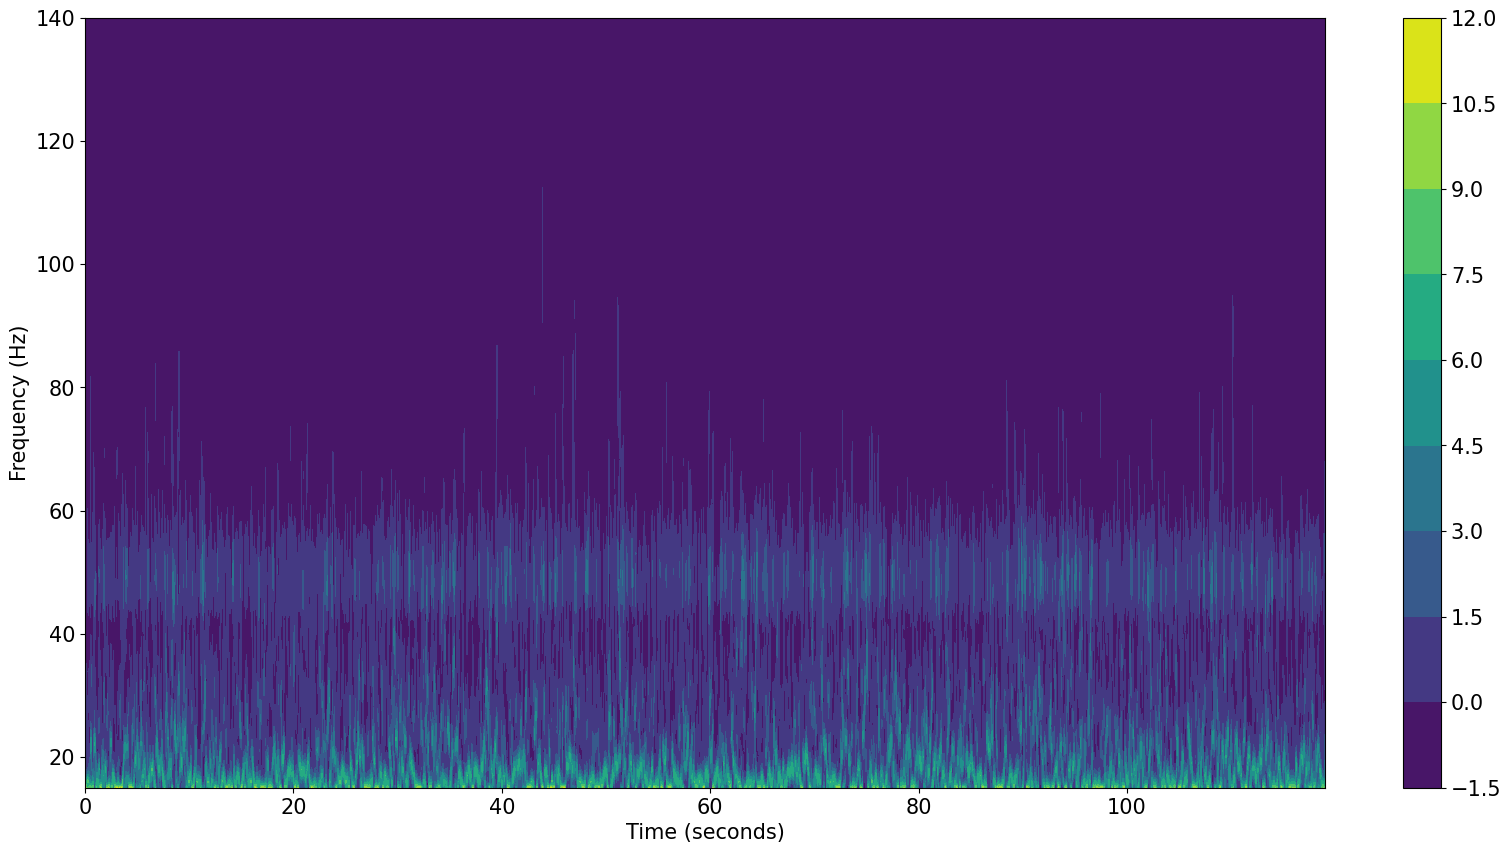

In [216]:
plt.gcf().set_size_inches(20, 10)
first_rem_wt=scipy.stats.zscore(first_rem_wt,axis=0) #Z-Score Normalize the dataset
plt.contourf(seconds,frequencies,first_rem_wt)
plt.colorbar()
plt.xlabel(r'Time (seconds)')
plt.ylabel(r'Frequency (Hz)')

In [217]:
sub_gamma, gamma, supra_gamma = tg_split(imask[1])
gamma_sig = np.sum(imask[0].T[gamma], axis=0)
supra_gamma_sig = np.sum(imask[0].T[supra_gamma], axis=0)
sub_gamma_sig = np.sum(imask[0].T[sub_gamma], axis=0)

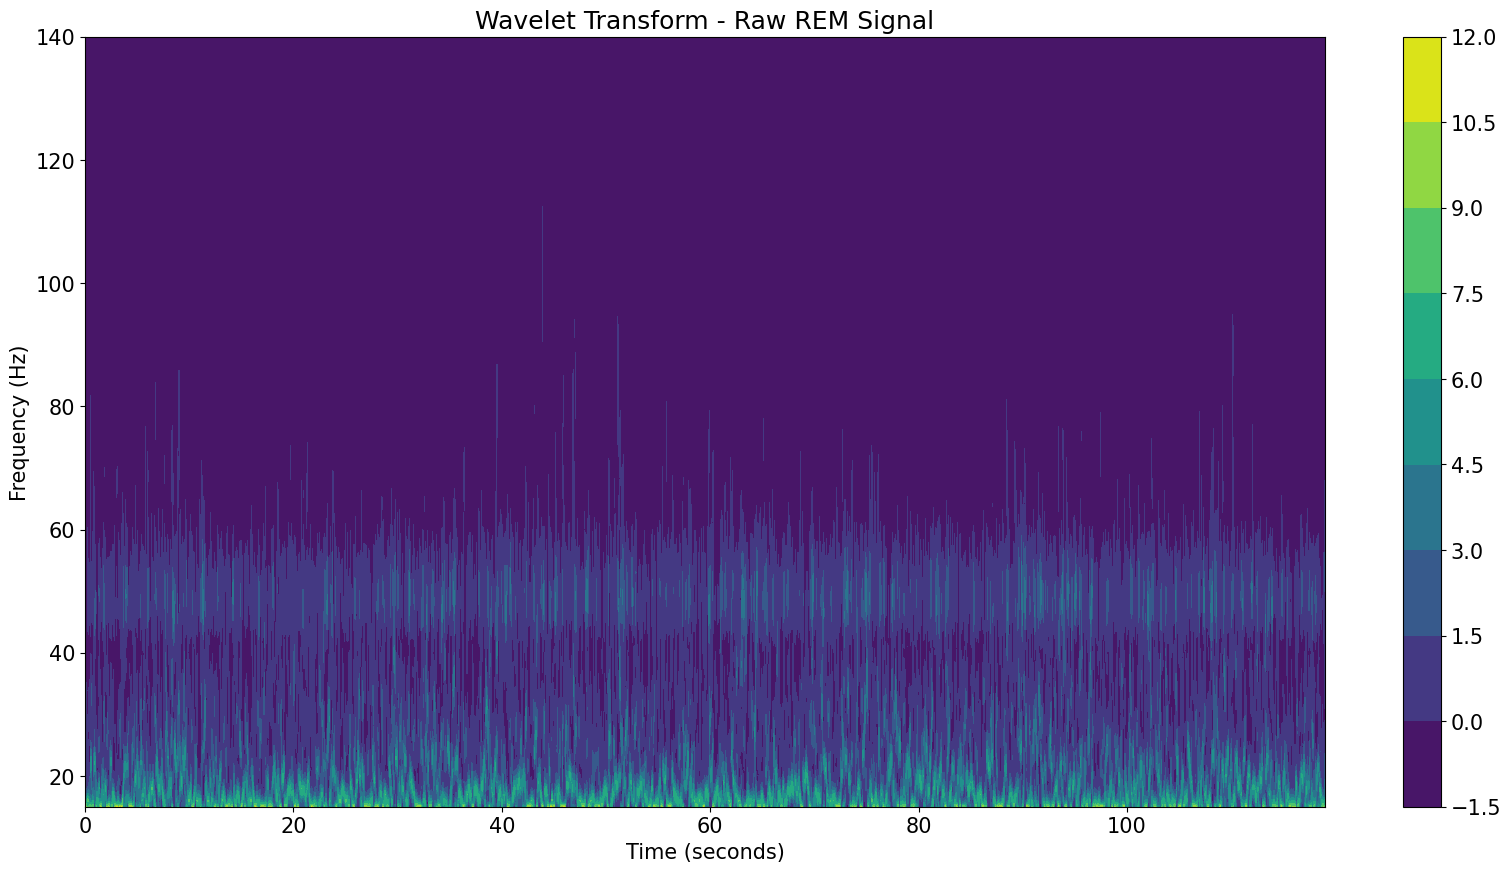

In [218]:
frequencies = np.arange(15, 141, 1)
gamma_range = (30, 120)
sample_rate = 2500

# Plot the raw REM signal wavelet transforms

time = len(first_rem) / s_rate
seconds = np.linspace(0, time, len(first_rem))

plt.figure(figsize=(20, 10))
normalized_raw_wt = scipy.stats.zscore(first_rem_wt, axis=0)  # Z-Score Normalize the dataset
plt.contourf(seconds, frequencies, normalized_raw_wt)
plt.colorbar()
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Wavelet Transform - Raw REM Signal')
plt.show()
     

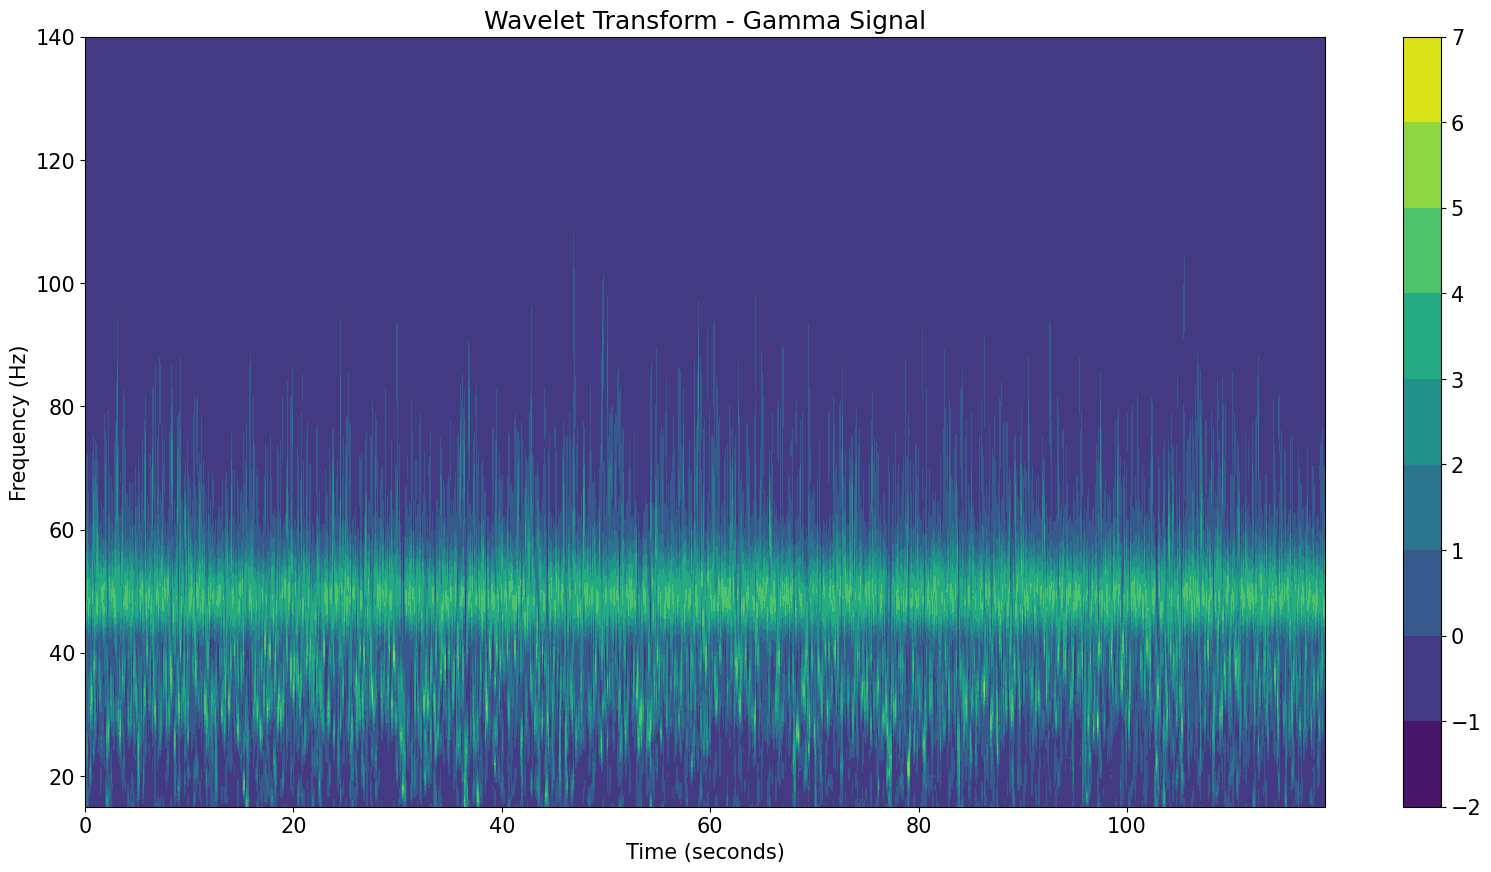

In [219]:
time = len(first_rem) / s_rate
seconds = np.linspace(0, time, len(first_rem))

plt.figure(figsize=(20, 10))
normalized_gamma_wt = scipy.stats.zscore(gamma_wt, axis=0)  # Z-Score Normalize the dataset
plt.contourf(seconds, frequencies, normalized_gamma_wt)
plt.colorbar()
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Wavelet Transform - Gamma Signal')
plt.show()

In [220]:
imf.shape

(297500, 6)

In [221]:
gamma_wt.shape

(126, 297500)

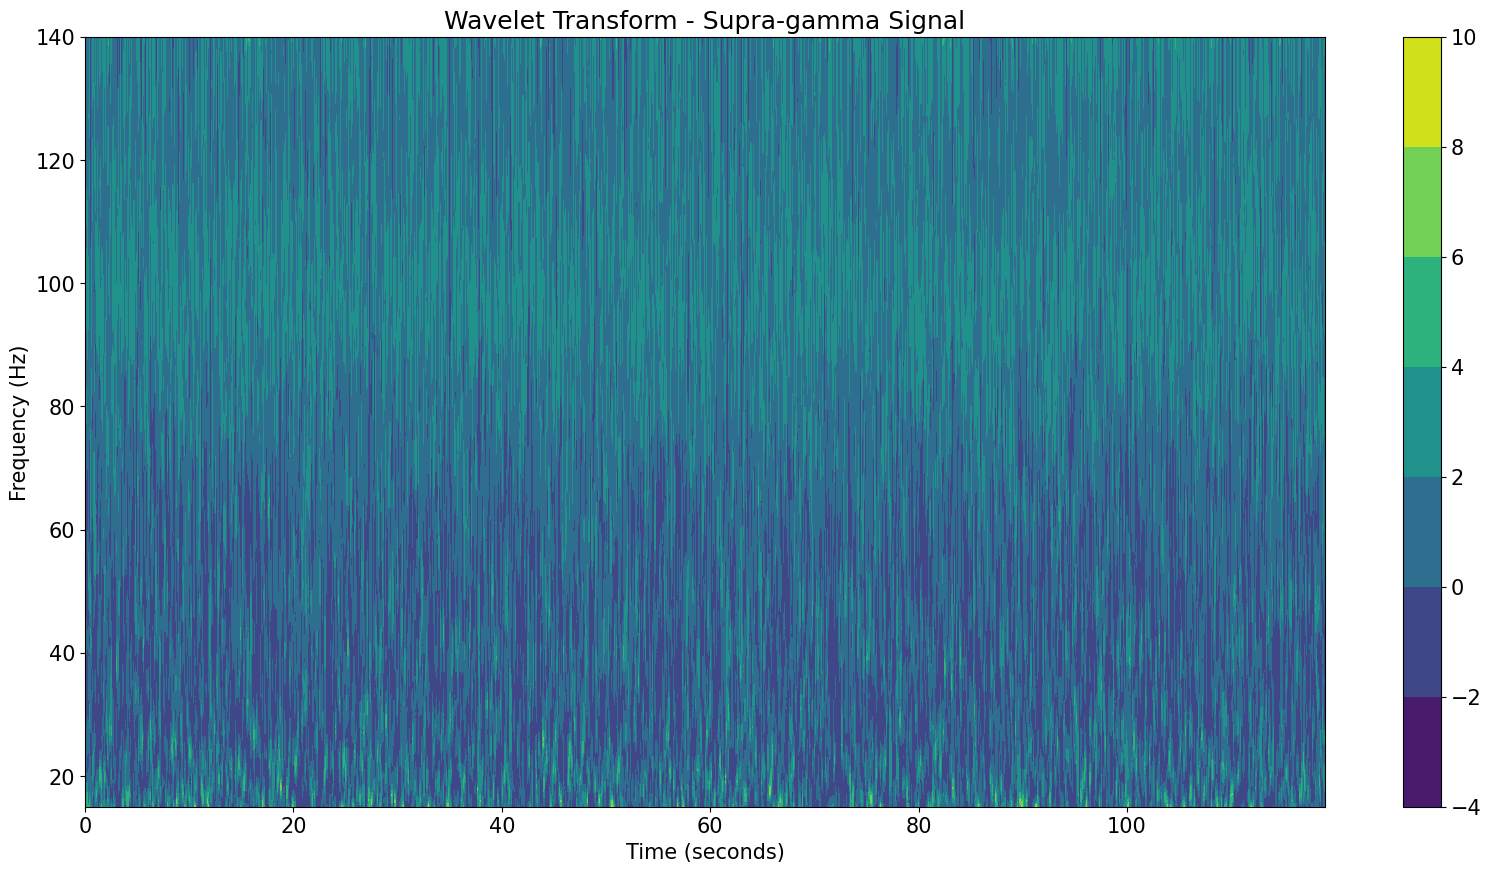

In [222]:
time = len(first_rem) / s_rate
seconds = np.linspace(0, time, len(first_rem))

plt.figure(figsize=(20, 10))
normalized_supra_gamma_wt = scipy.stats.zscore(supra_gamma_wt, axis=0)  # Z-Score Normalize the dataset
plt.contourf(seconds, frequencies, normalized_supra_gamma_wt)
plt.colorbar()
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Wavelet Transform - Supra-gamma Signal')
plt.show()
     

In [224]:
def get_cycles_data(x, rem_states, sample_rate, frequencies, gamma_range=(30, 120)):
    """
    Generate a nested dictionary containing extracted data and desired metadata of each REM epochs in the input sleep
    signal

    Parameters:
    x (numpy.ndarray): The input 1D sleep signal.
    rem_states (numpy.ndarray): A sleep state vector where 5 represents REM sleep and other values indicate non-REM.
    sample_rate (int or float): The sampling rate of the data.
    gamma_range (tuple, optional): A tuple defining the gamma frequency range (lower, upper).
            Default is (5, 12).

    Returns:
    rem_dict: A nested dictionary of extracted signal data and signal source metadata

    Notes:
    - The dictionary output structure comes out as below:
        |----REM 1
        |    |----start_end:
        |    |----IMFs:
        |    |----IMF Frequencies:
        |    |----Instantaneous Phases:
        |    |----Instantaneous Frequencies:
        |    |----Instantaneous Amplitudes:
        |    |----Cycles:
        |----REM (...)
        |    |--------(...)
    """

    # Squeezing dimensions
    x = np.squeeze(x)
    rem_states = np.squeeze(rem_states)

    print(x.shape)
    print(rem_states.shape)

    # Detect REM periods
    consecutive_rem_states = get_rem_states(rem_states, sample_rate).astype(int)

    if consecutive_rem_states.ndim == 3:
        consecutive_rem_states=np.squeeze(consecutive_rem_states,0)

    print(consecutive_rem_states.shape)

    # Intiializing variables
    wt_spectrum = []
    rem_imf = []
    rem_mask_freq = []
    instantaneous_phase = []
    instantaneous_freq = []
    instantaneous_amp = []
    sub_gamma_sig = np.empty((0,))
    gamma_peak_sig = np.empty((0,))
    cycles = np.empty((0, 5))
    rem_dict = {}
    sub_dict = rem_dict
    good_rem = []
    count = 0
    # Loop through each REM epoch
    for i, rem in enumerate(consecutive_rem_states):
        start = rem[0]
        end = rem[1]+1
        signal = x[start:end]

        # Extraction of IMFs and IMF Frequencies for current REM epoch
        print('Finding Intrinsic Mode Functions')
        imf, mask_freq = emd.sift.iterated_mask_sift(signal,
                                                 mask_0='zc',
                                                 sample_rate=sample_rate,
                                                 ret_mask_freq=True)

        # Extract Instantaneous Phase, Frequencies and Amplitudes of each IMF for current REM epoch
        print('Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF')
        IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'nht')

        # Identify sub-gamma, gamma, and supra-gamma frequencies
        sub_gamma, gamma, supra_gamma = tg_split(mask_freq, gamma_range)

        if np.any(gamma):
            print('gamma frequencies are valid')
            count += 1
            good_rem.append(i)
            sub_dict.setdefault(f'REM {count}', {})
        elif not np.any(gamma):
            print(f'No valid gamma frequencies for REM {i}')
            continue

        print(f'Processing REM {count} ')

        # Generate the time-frequency power spectrum
        print('Generating time-frequency matrix')
        wavelet_transform = morlet_wt(signal, sample_rate, frequencies, mode='amplitude')

        # print('Generating time-frequency matrix')
        # if wavelet =='gamma':
        #     wavelet_transform = morlet_wt(np.sum(imf.T[gamma], axis=0),
        #                                   sample_rate,
        #                                   frequencies,
        #                                   mode='amplitude')
        # elif wavelet == 'gamma':
        #     wavelet_transform = morlet_wt(np.sum(imf.T[supra_gamma], axis=0),
        #                                   sample_rate,
        #                                   frequencies,
        #                                   mode='amplitude')
        # else:
        #     wavelet_transform = morlet_wt(signal, sample_rate, frequencies, mode='amplitude')

        wt_spectrum.append(wavelet_transform)
        rem_imf.append(imf)
        rem_mask_freq.append(mask_freq)
        instantaneous_phase.append(IP)
        instantaneous_freq.append(IF)
        instantaneous_amp.append(IA)

        # Generate the gamma signal to detect cycles
        gamma_sig = np.sum(imf.T[gamma], axis=0)

        # Parse the sub-gamma signal of all REM periods into one variable to set amplitude threshold
        sub_gamma_sig = np.append(sub_gamma_sig, np.sum(imf.T[sub_gamma], axis=0))

        # Generate extrema locations and zero crossing on the generated gamma signal
        zero_x, trough, peak = extrema(np.sum(imf.T[gamma], axis=0))
        print(f'Number of zero crossings, {zero_x.shape}')

        # Create the cycles array for the current REM epoch
        zero_x = np.vstack((zero_x[:-2:2], zero_x[1:-1:2], zero_x[2::2])).T

        size_adjust = np.min([trough.shape[0], zero_x.shape[0], peak.shape[0]])
        zero_x = zero_x[:size_adjust]
        cycle = np.empty((size_adjust, 5))
        cycle[:, [0, 2, 4]] = zero_x
        if trough[0] < peak[0]:
            cycle[:, 1] = trough[:zero_x.shape[0]]
            cycle[:, 3] = peak[:zero_x.shape[0]]
        else:
            cycle[:, 3] = trough[:zero_x.shape[0]]
            cycle[:, 1] = peak[:zero_x.shape[0]]

        broken_cycle = cycle[~np.all(np.diff(cycle, axis=1) > 0, axis=1)]
        broken_cycle_mask = np.diff(broken_cycle, axis=1) > 0

        adjust_condition = np.all(np.all(broken_cycle_mask[1:] == [True, False, False, True],
                                         axis=0) == True)
        adjust_loc = np.where(np.all(np.diff(cycle, axis=1) > 0, axis=1) == False)[0][1:-1]

        fixed_cycle = broken_cycle[1:-1]
        if adjust_condition:
            fixed_cycle[:, 1] = cycle[adjust_loc - 1, 1]
            fixed_cycle[:, 3] = cycle[adjust_loc + 1, 3]
        else:
            fixed_cycle[:, 3] = cycle[adjust_loc - 1, 3]
            fixed_cycle[:, 1] = cycle[adjust_loc + 1, 1]

        cycle = cycle[np.all(np.diff(cycle, axis=1) > 0, axis=1)]
        cycle = np.vstack((cycle, fixed_cycle))
        if trough[0] < peak[0]:
            cycle = np.hstack((cycle[:-1, 1:-1], cycle[1:, :2]))
        else:
            cycle = np.hstack((cycle[:-1, 3].reshape((-1, 1)), cycle[1:, :-1]))
        print(f'Number of cycles, {cycle.shape}')
        # Create an array of amplitudes at the peaks
        gamma_peak_sig = np.append(gamma_peak_sig, gamma_sig[cycle[:, 2].astype(int)])
        cycles = np.vstack((cycles, cycle + start))

    # Set the minimum amplitude threshold and discard unsatisfactory gamma peaks
    min_peak_amp = 2 * sub_gamma_sig.std()
    peak_mask = gamma_peak_sig > min_peak_amp

    # Set the frequency threshold and discard and unsatisfactory difference between trough pairs
    upper_diff = np.floor(1000 / np.min(gamma_range))
    lower_diff = np.floor(1000 / np.max(gamma_range))
    diff_mask = np.logical_and(np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) > lower_diff,
                               np.diff(cycles[:, [0, -1]], axis=1) * (1000 / sample_rate) <= upper_diff)

    # Create a boolean mask that satisfy both the frequency and amplitude threshold criteria
    extrema_mask = np.logical_and(np.squeeze(diff_mask), peak_mask)

    # Pass the boolean mask on the cycles array to discard any unsatisfactory cycles
    cycles = cycles[extrema_mask]

    # Place outputs in a nested dictionary
    for j, rem in enumerate(rem_dict.values()):
        good_rem_states = consecutive_rem_states[good_rem]
        rem['start-end'] = good_rem_states[j]
        rem['wavelet_transform'] = wt_spectrum[j]
        rem['IMFs'] = rem_imf[j]
        rem['IMF_Frequencies'] = rem_mask_freq[j]
        rem['Instantaneous Phases'] = instantaneous_phase[j]
        rem['Instantaneous Frequencies'] = instantaneous_freq[j]
        rem['Instantaneous Amplitudes'] = instantaneous_amp[j]
        cycles_mask = (cycles > good_rem_states[j, 0]) & (cycles < good_rem_states[j, 1])
        cycles_mask = np.all(cycles_mask == True, axis=1)
        if cycles[cycles_mask].size == 0:
            rem_cycles = np.zeros((1, 5)).astype(int) # Empty Cycles Array (none of the cycles passed our thresholds)
        else:
            rem_cycles = cycles[cycles_mask].astype(int)
        rem['Cycles'] = rem_cycles

    return rem_dict
     

In [204]:
rem_dict=get_cycles_data(lfp,states,s_rate,frequencies)

(27004246,)
(10801,)
(5, 2)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 1 
Generating time-frequency matrix
Number of zero crossings, (17810,)
Number of cycles, (8896, 5)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 2 
Generating time-frequency matrix
Number of zero crossings, (3133,)
Number of cycles, (1546, 5)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 3 
Generating time-frequency matrix
Number of zero crossings, (5742,)
Number of cycles, (2861, 5)
Finding Intrinsic Mode Functions
Extracting Instantaneous Phase, Frequencies and Amplitudes of each IMF
Theta frequencies are valid
Processing REM 4 
Generating time-frequency matrix
Number of zero crossings, (1455,)
Number of cycles, (

In [227]:
first_rem_cycles=rem_dict['REM 1']['Cycles']
print(first_rem_cycles.shape)
first_rem_wt=rem_dict['REM 1']['wavelet_transform']
print(first_rem_wt.shape)

(1, 5)
(126, 297501)


TypeError: Input z must be at least a (2, 2) shaped array, but has shape (126, 0)

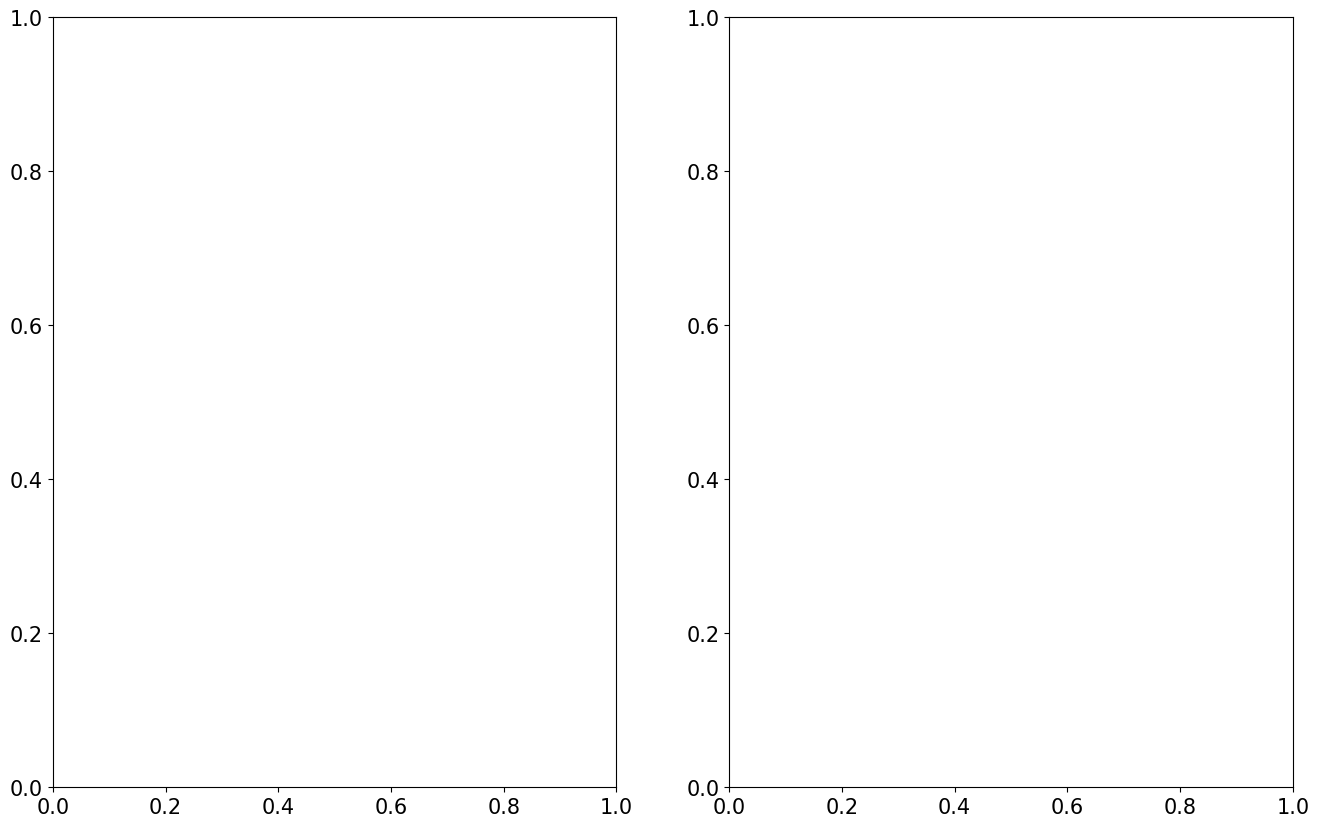

In [225]:
single_cycle=first_rem_cycles[0]-rem_dict['REM 1']['start-end'][0]
fig,ax=plt.subplots(1,2,figsize=(16,10))
plt.rcParams.update({'font.size': 15})
ax[0].contourf(seconds[single_cycle[0]:single_cycle[-1]+1],frequencies,first_rem_wt[:,single_cycle[0]:single_cycle[-1]+1])
ax[0].set_xlabel(r'Time (seconds)')
ax[0].set_ylabel(r'Frequency (Hz)')
ax[0].set_title('Single cycle Raw Signal TF Matrix')
ax[1].contourf(seconds[single_cycle[0]:single_cycle[-1]+1],frequencies,supra_gamma_wt[:,single_cycle[0]:single_cycle[-1]+1])
ax[1].set_xlabel(r'Time (seconds)')
ax[1].set_ylabel(r'Frequency (Hz)')
ax[1].set_title('Single cycle Supra-gamma Signal TF Matrix')#imf = emd.sift.iterated_mask_sift(first_rem,sample_rate=s_rate) #doubt
IP, IF, IA = emd.spectra.frequency_transform(normalized_gamma_wt.T, s_rate, 'nht')

# Extract cycle locations
all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)
good_cycles = emd.cycles.get_cycle_vector(IP, return_good=True)

In [228]:
#imf = emd.sift.iterated_mask_sift(first_rem,sample_rate=s_rate) #doubt
IP, IF, IA = emd.spectra.frequency_transform(normalized_gamma_wt.T, s_rate, 'nht')

# Extract cycle locations
all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)
good_cycles = emd.cycles.get_cycle_vector(IP, return_good=True)

print(IF)

[[-1.98243043e+01 -5.57239277e-01 -2.34955333e+01 ... -3.94713991e+01
  -3.97719520e+01 -3.93049222e+01]
 [-1.98243043e+01 -5.57239277e-01 -2.34955333e+01 ... -3.94713991e+01
  -3.97719520e+01 -3.93049222e+01]
 [-7.82713226e+00 -0.00000000e+00 -1.34048968e+01 ... -1.31336463e+01
  -1.32810470e+01 -1.29826506e+01]
 ...
 [ 9.49693557e+00  5.08915241e-01  9.11298732e+00 ...  1.25620069e+01
   1.26201720e+01  1.25137333e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.36019407e+01
   3.38316591e+01  3.35315503e+01]
 [ 2.56555006e-11  1.24048032e-11  3.65520439e-11 ...  3.36019407e+01
   3.38316591e+01  3.35315503e+01]]


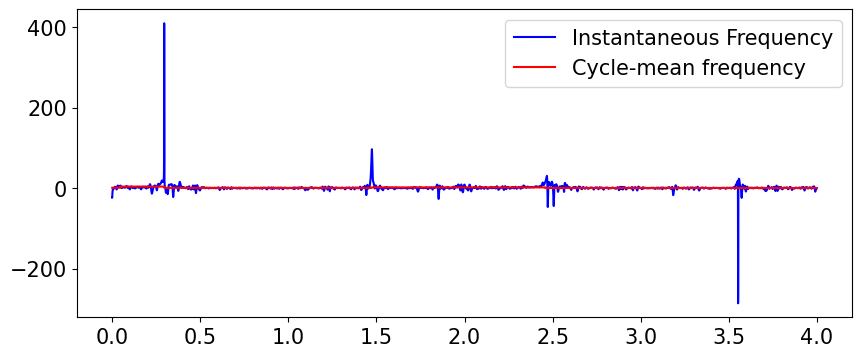

In [208]:
cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 2], IF[:, 2], out='samples', func=np.mean)

# Make a summary figure
plt.figure(figsize=(10, 4))
plt.plot(seconds[:s_rate*4], IF[:s_rate*4, 2], 'b')
plt.plot(seconds[:s_rate*4], cycle_freq[:s_rate*4], 'r')
plt.legend(['Instantaneous Frequency', 'Cycle-mean frequency'])